Описание датасета

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from datetime import datetime
from matplotlib import rcParams
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")


SEED = 2021
USE_CORES = os.cpu_count() - 1
# каталог с файлами: train.csv, test.csv и sample_submission.csv
PATH_FILES = r'D:\python-txt\real_estate'
# каталог с результатами работы
PATH_EXPORT = r'D:\python-txt\real_estate'
FILE_TRAIN = os.path.join(PATH_FILES, 'train.csv')
FILE_TEST = os.path.join(PATH_FILES, 'test.csv')
FILE_YEARS = os.path.join(PATH_EXPORT, 'changed_years.csv')
FILE_HOUSES = os.path.join(PATH_EXPORT, 'moscow_houses.csv')
FILE_PREPROCESS = os.path.join(PATH_EXPORT, 'df_preprocess.csv')
FILE_WITH_FEATURES = os.path.join(PATH_EXPORT, 'df_all.csv')
FILE_SAMPLE = os.path.join(PATH_FILES, 'sample_submission.csv')
FILE_SUBMIT = os.path.join(PATH_EXPORT, 'submission.csv')

show_columns = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                'other_sq', 'Floor', 'HouseFloor', 'HouseYear', 'Price',
                'learn', 'kitchen_good', 'kt_ratio', 'rm_ratio']

rcParams.update({'font.size': 14})  # размер шрифта на графиках
pd.options.display.max_columns = 100
global_start_time = time.time()


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time.time() - time_start
    hrs = time_apply // 3600
    min = time_apply % 3600
    sec = min % 60
    print(f'Время обработки: {hrs:.0f} час {min // 60:.0f} мин {sec:.1f} сек')

In [2]:
def fill_square(row, name_field, good_field):
    """
    Заполнение Square и KitchenSquare
    :param row: строка датафрейма
    :param name_field: имя поля, которое заполняем
    :param good_field: имя поля для отбора записей, какие корректируем
    :return: площадь
    """

    def filtered_df(conditions_filtered):
        """
        фильтрация ДФ по условиям
        :param conditions_filtered: условия
        :return: фильтрованный ДФ
        """
        df_temp = df_all.loc[(df_all[good_field] > 0) &
                             (df_all['Rooms'] == row['Rooms']) &
                             conditions_filtered[0] &
                             conditions_filtered[1] &
                             conditions_filtered[2] &
                             conditions_filtered[3]]
        return df_temp

    # если это правильная запись - просто выход и возврат её значения
    if row[good_field]:
        return row[name_field]

    koefic = 0.1
    square = row['Square']
    min_sq = square * (1 - koefic)
    max_sq = square * (1 + koefic)

    conditions = [(df_all['DistrictId'] == row['DistrictId']),
                  (df_all['HouseYear'] == row['HouseYear']),
                  (df_all['Square'] > min_sq),
                  (df_all['Square'] < max_sq),
                  True]
    if name_field == 'Square':
        idx_end = 4
        for idx_c in range(idx_end - 1, len(conditions)):
            conditions[idx_c] = True
    else:
        idx_end = len(conditions)
    df_tmp = pd.DataFrame()
    for idx_c in range(idx_end):
        if idx_c != 2:
            df_tmp = filtered_df(conditions)
            if len(df_tmp):
                break
        conditions[idx_c] = True
    if len(df_tmp):
        if name_field == 'KitchenSquare':
            return int(round(df_tmp[name_field].median() + 0.1, 0))
        else:
            sq_mean = df_tmp[name_field].mean()
            if name_field == 'LifeSquare' and sq_mean > square:
                sq_mean = square
            return sq_mean
    return row[name_field]


def recalc_square():
    """
    расчет первых фич
    :return: None
    """
    df_all['kt_ratio'] = df_all.Square / df_all.KitchenSquare
    df_all['rm_ratio'] = df_all.LifeSquare / df_all.Rooms
    df_all['other_sq'] = df_all.Square - df_all.KitchenSquare - df_all.LifeSquare
    df_all['int_square'] = df_all.Square.round(0).astype(int)
    

def make_grp_df(cond_grp, inv_cond, add_cond=True, chk_floor=None,
                test_index=None):
    # для проставления адекватной площади кухни сгруппируем данные
    # по кол-ву комнат и целой площади
    # cond_grp = (df_all.other_sq > 0) | (df_all.kitchen_good > 0)
    # inv_cond = ((df_all.other_sq <= 0) & (df_all.kitchen_good < 1))

    def calc_min_max(square, koefic=None, check_floor=None):
        if not koefic:
            if square <= 50:
                koefic = 0.1
            elif square < 150:
                koefic = 0.05
            else:
                koefic = 0.2
        min_sq = square * (1 - koefic)
        max_sq = square * (1 + koefic)

        if chk_floor:
            add_floor = (df_all.HouseFloor == check_floor)
        else:
            add_floor = True

        return df_all[(df_all['Rooms'] == rooms) &
                      (df_all['Square'] > min_sq) &
                      (df_all['Square'] < max_sq) & add_cond & add_floor]

    grpr = df_all[cond_grp].groupby(['Rooms', 'int_square'],
                                    as_index=False).agg(
        {'LifeSquare': 'median',
         'KitchenSquare': 'median',
         'HouseFloor': 'median',
         'HouseYear': lambda x: x.value_counts().index[0]})
    grpr.columns = ['Rooms', 'int_square', 'lq_median', 'ks_median',
                    'hf_median', 'hy_mode']
    grpr['rooms_intsq'] = grpr.Rooms.astype(str) + '_' + grpr.int_square.astype(str)
    grpr['rooms_intsq'] = grpr['rooms_intsq'].astype('category')

    # проверим все ли квартиры найдутся в группировке
    if test_index:
        no_found = df_all[df_all.index == test_index]
    else:
        no_found = df_all[
            inv_cond & ~df_all.rooms_intsq.isin(grpr.rooms_intsq)].sort_values(
            ['Rooms', 'Square'])
    # Добавим в группировку строки из этой таблицы для отсутствующих значений
    # int_square с группировкой по диапазону Square +/- 10%.
    for idx in no_found.index:
        rooms = no_found.loc[idx, 'Rooms']
        rsquare = no_found.loc[idx, 'Square']
        int_square = no_found.loc[idx, 'int_square']
        for koef in (None, 0.2, 0.25, 0.3):
            tmp = calc_min_max(rsquare, koef, chk_floor)
            if len(tmp):
                break
        if not len(tmp):
            for koef in (None, 0.2, 0.25, 0.3):
                tmp = calc_min_max(rsquare, koef, chk_floor-1)
                if len(tmp):
                    break
        # Rooms	int_sq cnt sq_median lq_median ks_median os_median rooms_intsq
        idx_rooms_intsq = f'{rooms}_{int_square}'
        if idx_rooms_intsq not in grpr.rooms_intsq.values:
            grpr.loc[len(grpr)] = [rooms, int_square,
                                   tmp.LifeSquare.median(),
                                   tmp.KitchenSquare.median(),
                                   tmp.HouseFloor.median(),
                                   tmp.HouseYear.value_counts().index[0],
                                   idx_rooms_intsq]
    grpr.ks_median = (grpr.ks_median + 0.1).round(0).astype(int)
    grpr.hf_median = (grpr.hf_median + 0.1).round(0).astype(int)
    grpr.hy_mode = (grpr.hy_mode + 0.1).round(0).astype(int)
    # установка нового индекса
    grpr = grpr.set_index('rooms_intsq')
    return grpr


def group_years(concan_floors=200):
    """
    Группировка данных для отображения максимальной этажности домов по годам
    :return: объединенные ДФ по строкам и столбцам
    """
    dfg = df_all.groupby('HouseYear', as_index=False).HouseFloor.max().astype(int)
    dfg['DataKind'] = 'Датасет'
    dfc = df_all[df_all.HouseFloor < 
                 concan_floors].groupby('HouseYear', as_index=False).HouseFloor.max().astype(int)
    dfc['DataKind'] = 'Датасет'

    # посмотрим на распределение этажности домов по годам с сайта
    # https://dom.mingkh.ru/moskva/moskva/
    if os.access(FILE_HOUSES, os.F_OK):
        df_houses = pd.read_csv(FILE_HOUSES, sep=';', index_col='pos')
        df_houses['area'] = pd.to_numeric(df_houses['area'], errors='coerce')
        df_houses['HouseYear'] = pd.to_numeric(df_houses['HouseYear'],
                                               errors='coerce')
        df_houses['HouseFloor'] = pd.to_numeric(df_houses['HouseFloor'],
                                                errors='coerce')
        df_houses.dropna(inplace=True)
        df_houses.HouseYear = df_houses.HouseYear.astype(int)
        df_houses.HouseFloor = df_houses.HouseFloor.astype(int)
        df_houses.HouseYear = df_houses.HouseYear - 1
        msk = df_houses[df_houses.HouseYear >= dfg.HouseYear.min()]
        msk = msk.groupby('HouseYear', as_index=False).HouseFloor.max().astype(int)
    else:
        years_floors = ([1957, 14], [1960, 12], [1961, 12], [1977, 22])
        msk = dfg.copy(deep=True)
        for year, floor in years_floors:
            msk.loc[msk.HouseYear == year, 'HouseFloor'] = floor        
    msk.sort_values('HouseYear')
    msk['DataKind'] = 'Cайт ЖКХ'
    df_concat = pd.concat([dfc, msk], axis=0)
    df_merged = dfg[['HouseYear', 'HouseFloor']].merge(
        msk[['HouseYear', 'HouseFloor']], on='HouseYear')
    df_merged.columns = ['HouseYear', 'HouseFloor', 'HouseFloor_MSK']
    return df_concat, df_merged

In [3]:
# обучающая выборка
train = pd.read_csv(FILE_TRAIN, index_col='Id')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 11809 to 7202
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

#### Посмотрим на целевую переменную

In [4]:
train['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

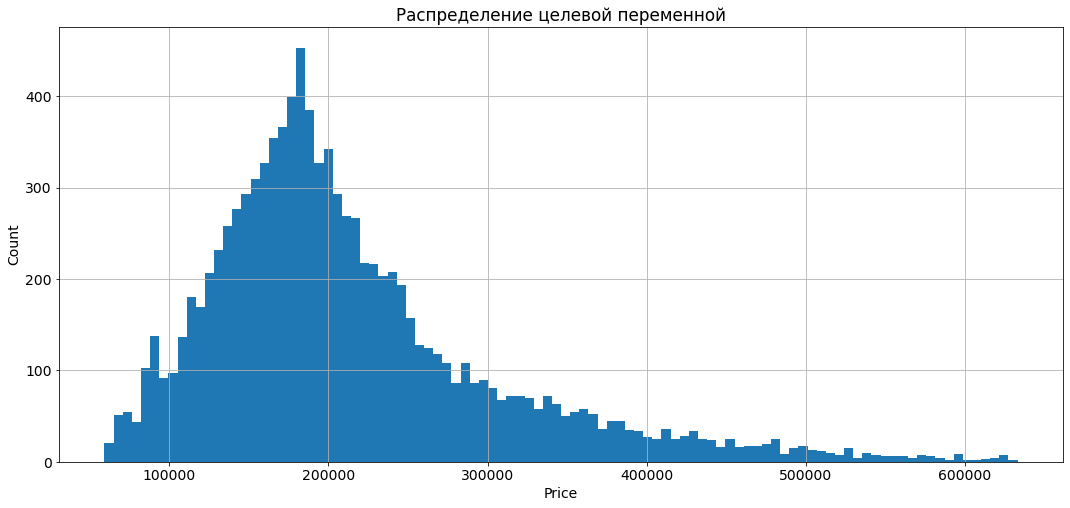

In [5]:
train['Price'].hist(bins=100, figsize = (18, 8))
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Распределение целевой переменной')
plt.show()

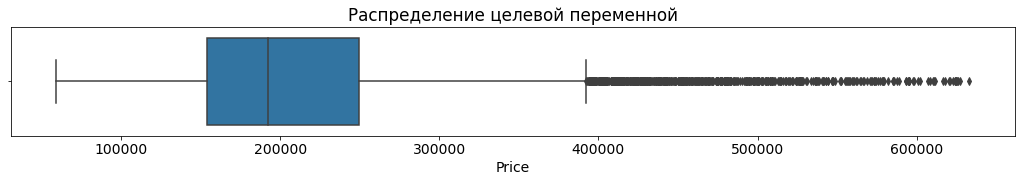

In [6]:
plt.figure(figsize=(18, 2))
sns.boxplot(data=train, x='Price')
plt.title('Распределение целевой переменной')
plt.show()

In [7]:
# посмотрим на квартиры с ценой более 600тыс
train[train['Price']>600000].sort_values('Price')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
3876,100,4.0,104.769022,79.316650,8.0,4,8.0,1960,0.200147,B,B,23,3975,8,770.0,2,0,B,600903.828562
12251,26,3.0,116.052846,56.051303,14.0,7,30.0,2013,0.000000,B,B,36,6714,2,2672.0,0,2,B,601914.014560
15749,66,3.0,78.747853,33.885760,11.0,2,5.0,1955,0.161976,B,A,31,7010,5,4508.0,3,7,B,606958.937510
4971,169,5.0,117.855969,76.561318,9.0,12,14.0,2001,0.178917,B,B,18,3594,4,192.0,1,5,B,608674.130507
6808,146,3.0,106.867638,64.341756,14.0,4,22.0,2011,0.236108,B,B,16,3893,27,NaN,3,10,B,610557.405615
13630,24,3.0,127.141143,4.811405,1.0,3,1.0,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B,611250.912034
9840,108,3.0,78.824038,53.016323,8.0,2,8.0,1958,0.000000,B,B,23,3684,2,NaN,0,4,B,611542.063430
13532,146,3.0,106.246398,64.451747,14.0,9,18.0,2010,0.236108,B,B,16,3893,27,NaN,3,10,B,616857.135464
1225,157,3.0,76.460332,49.979154,8.0,9,8.0,1960,0.000000,B,B,30,7538,87,4702.0,5,5,B,617749.118586


#### Цена квартиры практически нормально распределена, но с длинным "хвостом" с высокими ценами, возможно элитные квартиры или исторические здания - оставим как есть, т.е. выбросы по цене не будем обрабатывать.

In [8]:
# тестовая выборка
test = pd.read_csv(FILE_TEST, index_col='Id')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 4567 to 11004
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: f

Видим, что в обеих выборках есть пропуски в полях LifeSquare и Healthcare_1.  

In [9]:
# объединим обучающую и тестовую выборки в один датафрейм для заполнения
# отсутствующих значений, но перед этим поля отметки выборок.
train['learn'] = 1
test['learn'] = 0
df_all = pd.concat([train, test])
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 11809 to 11004
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     15000 non-null  int64  
 1   Rooms          15000 non-null  float64
 2   Square         15000 non-null  float64
 3   LifeSquare     11846 non-null  float64
 4   KitchenSquare  15000 non-null  float64
 5   Floor          15000 non-null  int64  
 6   HouseFloor     15000 non-null  float64
 7   HouseYear      15000 non-null  int64  
 8   Ecology_1      15000 non-null  float64
 9   Ecology_2      15000 non-null  object 
 10  Ecology_3      15000 non-null  object 
 11  Social_1       15000 non-null  int64  
 12  Social_2       15000 non-null  int64  
 13  Social_3       15000 non-null  int64  
 14  Healthcare_1   7825 non-null   float64
 15  Helthcare_2    15000 non-null  int64  
 16  Shops_1        15000 non-null  int64  
 17  Shops_2        15000 non-null  object 
 18  Pr

Колонка "Healthcare_1" содержит почти 50% пропусков: её исключаем из датасета

In [10]:
df_all.drop('Healthcare_1', axis=1, inplace=True)
# посмотрим на датасет
df_all.head(20)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,learn
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,0,0,B,305018.871089,1
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1,0,B,177734.553407,1
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,3,1,B,282078.720850,1
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,0,1,B,168106.007630,1
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,0,6,B,343995.102962,1
5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2,4,B,161044.944138,1
8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,0,3,B,142402.739272,1
13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,5,5,B,326174.175191,1
9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,0,1,B,160400.401732,1


Видим, что колонки:DistrictId, Rooms, HouseFloor, KitchenSquare загрузились вещественными типами, преобразуем их в целый тип данных.

In [11]:
df_all.DistrictId = df_all.DistrictId.astype(int)
df_all.Rooms = df_all.Rooms.astype(int)
df_all.HouseFloor = df_all.HouseFloor.astype(int)
df_all.KitchenSquare = df_all.KitchenSquare.astype(int)
recalc_square()
# пропишем, что изначально эти признаки в датасете хорошие
df_all['rooms_good'] = 1  # количество комнат
df_all['square_good'] = 1  # общая площадь верная
df_all['livesq_good'] = 1  # жилая площадь верная
df_all['orig_both_sq'] = 1  # обе площади верны
df_all['livesq_nonan'] = 1  # жилая площадь не нулевая
df_all['kitchen_good'] = 1  # площадь кухни правильная
df_all['other_sq_good'] = 1  # нежилая площадь не отрицательная
df_all['rm_ratio_good'] = 1  # средняя площадь комнаты > 9.8
df_all['house_fl_good'] = 1  # этажность дома верная
df_all['house_fl_nonan'] = 1  # этаж этажность дома не нулевая
df_all['house_hy_good'] = 1  # год постройки дома верный
df_all.loc[df_all.other_sq <= 0, 'other_sq_good'] = 0

In [12]:
df_all.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,learn,kt_ratio,rm_ratio,other_sq,int_square,rooms_good,square_good,livesq_good,orig_both_sq,livesq_nonan,kitchen_good,other_sq_good,rm_ratio_good,house_fl_good,house_fl_nonan,house_hy_good
count,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,10000.000000,15000.000000,1.500000e+04,1.184600e+04,11846.000000,15000.000000,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.000000,15000.0,15000.0,15000.0,15000.0
mean,50.693600,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1.319467,4.235133,214138.857399,0.666667,inf,inf,10.995685,56.358267,1.0,1.0,1.0,1.0,1.0,1.0,0.914467,1.0,1.0,1.0,1.0
std,43.786257,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1.489012,4.796545,92872.293865,0.471420,NaN,NaN,74.331151,20.429055,0.0,0.0,0.0,0.0,0.0,0.0,0.279683,0.0,0.0,0.0,0.0
min,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,1.638409e-02,6.669799e-02,-7399.897712,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0
25%,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942,0.000000,6.067483e+00,1.534973e+01,7.478459,42.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0
50%,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879,1.000000,8.288698e+00,1.749705e+01,11.373241,53.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0
75%,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,2.000000,6.000000,249135.462171,1.000000,4.401112e+01,2.215533e+01,15.802570,66.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0
max,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570,1.000000,inf,inf,134.899280,641.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0


Посмотрим какие значения встречаются в колонках.

In [13]:
sorted(df_all.HouseYear.unique(), reverse=True)

[20052011,
 4968,
 2020,
 2019,
 2018,
 2017,
 2016,
 2015,
 2014,
 2013,
 2012,
 2011,
 2010,
 2009,
 2008,
 2007,
 2006,
 2005,
 2004,
 2003,
 2002,
 2001,
 2000,
 1999,
 1998,
 1997,
 1996,
 1995,
 1994,
 1993,
 1992,
 1991,
 1990,
 1989,
 1988,
 1987,
 1986,
 1985,
 1984,
 1983,
 1982,
 1981,
 1980,
 1979,
 1978,
 1977,
 1976,
 1975,
 1974,
 1973,
 1972,
 1971,
 1970,
 1969,
 1968,
 1967,
 1966,
 1965,
 1964,
 1963,
 1962,
 1961,
 1960,
 1959,
 1958,
 1957,
 1956,
 1955,
 1954,
 1953,
 1952,
 1951,
 1950,
 1949,
 1948,
 1947,
 1943,
 1942,
 1941,
 1940,
 1939,
 1938,
 1937,
 1936,
 1935,
 1934,
 1933,
 1932,
 1931,
 1930,
 1929,
 1928,
 1927,
 1926,
 1920,
 1919,
 1918,
 1917,
 1916,
 1914,
 1912,
 1911,
 1910,
 1909,
 1908]

In [14]:
# исправим 2 ошибочных года
df_all.loc[df_all.HouseYear == 4968, 'HouseYear'] = 1968
df_all.loc[df_all.HouseYear == 20052011, 'HouseYear'] = 2011
df_all.loc[df_all['HouseYear'] > 2020, 'HouseYear'] = 2020

In [15]:
# похоже на то, что если у дома неизвестен год ему ставили 1977
df_all.HouseYear.value_counts()

1977    3950
2016     477
2015     458
2017     449
2014     308
        ... 
1949       1
1909       1
1916       1
1908       1
1920       1
Name: HouseYear, Length: 103, dtype: int64

In [16]:
df_all.query('HouseYear == 1977').HouseFloor.sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        30,  31,  40,  99, 117])

Посмотрим на распределение квартир по количеству комнат

In [17]:
group_rooms = df_all.groupby('Rooms').aggregate({'DistrictId': 'count',
                                                 'Square': ['mean', 'median'],
                                                 'LifeSquare': ['mean', 'median'],
                                                 'KitchenSquare': ['mean', 'median']})
group_rooms.columns = ['count', 'sq_mean', 'sq_median', 'lq_mean', 'lq_median', 'ks_mean', 'ks_median']
group_rooms.round(1)

,count,sq_mean,sq_median,lq_mean,lq_median,ks_mean,ks_median
Rooms,,,,,,,
0,10,84.6,78.9,87.0,85.1,2.1,0.0
1,5474,41.2,40.3,25.0,21.7,6.1,6.0
2,5910,56.8,55.8,36.1,32.6,5.8,6.0
3,3334,77.0,77.5,53.4,47.0,6.7,7.0
4,240,96.9,97.4,65.4,64.1,8.3,8.5
5,25,120.7,117.9,81.5,79.8,9.6,9.0
6,3,131.2,110.8,71.4,71.4,7.3,6.0
10,2,60.0,60.0,37.3,37.3,10.0,10.0
17,1,52.9,52.9,32.5,32.5,8.0,8.0


Количество комнат = 0 это явная ошибка в данных, и количество комнат более 6 вызывает сомнение.

In [18]:
df_all.loc[(df_all.Rooms == 0) | (df_all.Rooms > 6), 'rooms_good'] = 0
tmp = df_all[df_all.rooms_good == 0].sort_values(['Rooms', 'DistrictId', 'Square'])
tmp[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio
Id,,,,,,,,,,,,,,
456,6,0,81.491446,NaN,0,NaN,4,0,1977,212864.799112,1,1,inf,NaN
3224,27,0,2.377248,0.873147,0,1.504101,1,0,1977,126596.941798,1,1,inf,inf
7317,27,0,41.790881,NaN,0,NaN,13,0,1977,98129.976788,1,1,inf,NaN
10729,27,0,76.345154,42.820796,12,21.524358,14,0,1977,NaN,0,1,6.362096,inf
9443,27,0,87.762616,85.125471,0,2.637145,5,15,1977,219281.918007,1,1,inf,inf
12638,27,0,138.427694,136.215499,0,2.212195,4,3,2016,268394.744389,1,1,inf,inf
7917,27,0,212.932361,211.231125,0,1.701236,2,3,2008,302211.260887,1,1,inf,inf
770,28,0,49.483501,NaN,0,NaN,16,0,2015,217009.338463,1,1,inf,NaN
3343,58,0,116.824201,113.692424,0,3.131777,3,3,1977,NaN,0,1,inf,inf


Посмотрим на квартиры в районах с проблемными квартирами из list_index.

In [19]:
list_index = tmp.index
districts = tmp.DistrictId.unique()
tmp = df_all.query('DistrictId in @districts and index not in @list_index')
tmp_rooms = tmp.groupby(['DistrictId', 'Rooms'],
                        as_index=False).aggregate({'Floor': 'count',
                                                   'Square': 'median',
                                                   'LifeSquare': 'median',
                                                   'KitchenSquare': 'median'})
tmp_rooms.columns = ['DistrictId', 'Rooms', 'count', 'sq_median', 'lq_median', 'ks_median']
tmp_rooms.round(1)

,DistrictId,Rooms,count,sq_median,lq_median,ks_median
0,1,1,376,42.3,40.0,1.0
1,1,2,422,64.2,54.2,1.0
2,1,3,196,81.6,63.9,1.0
3,1,4,1,99.9,67.3,10.0
4,6,1,312,42.0,37.2,1.0
5,6,2,309,63.7,41.1,1.0
6,6,3,146,79.9,50.5,1.0
7,9,1,130,42.6,22.0,8.0
8,9,2,161,57.9,31.6,8.0
9,9,3,128,78.3,46.3,8.0


In [20]:
# заполним отсутствующие количества комнат по минимальной разнице площади
# квартиры и медианного значения площади в этом районе
for idx in list_index:
    id_dst = df_all.loc[idx, 'DistrictId']
    tmp_rooms['delta'] = abs(tmp_rooms.sq_median - df_all.loc[idx, 'Square'])
    idx_min = tmp_rooms.query('DistrictId == @id_dst').delta.idxmin()
    df_all.loc[idx, 'Rooms'] = int(tmp_rooms.loc[idx_min]['Rooms'])
df_all.Rooms.value_counts()

2    5914
1    5476
3    3337
4     242
5      27
6       4
Name: Rooms, dtype: int64

In [21]:
# при сопоставлении кол-ва комнат, площади и цены были выявлены такие выбросы
tmp = df_all[df_all.Rooms == 5]
tmp = tmp[tmp.Price < tmp.Price.median() / 2]
tmp[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio
Id,,,,,,,,,,,,,,
6358,27,5,42.003293,NaN,0,NaN,5,12,1977,112693.641769,1,1,inf,NaN
7317,27,5,41.790881,NaN,0,NaN,13,0,1977,98129.976788,1,1,inf,NaN
7594,53,5,39.906082,39.394024,1,-0.487942,5,1,1977,206148.845716,1,1,39.906082,7.878805
3224,27,5,2.377248,0.873147,0,1.504101,1,0,1977,126596.941798,1,1,inf,inf


In [22]:
# площадь соответствует количеству комнат = 1 с медианной площадью 40.3
for idx in tmp.index:
    df_all.loc[idx, 'Rooms'] = 1
    df_all.loc[idx, 'rooms_good'] = 0
df_all.Rooms.value_counts()    

2    5914
1    5480
3    3337
4     242
5      23
6       4
Name: Rooms, dtype: int64

Видим, что выбросы по количеству комнат устранены. Смотрим на разброс площадей.

Square, Rooms=1


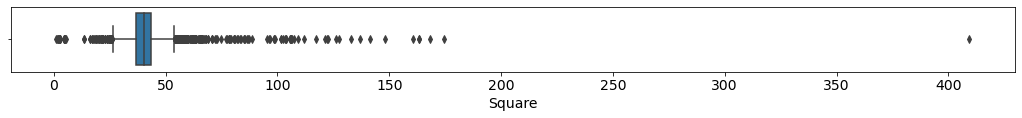

Square, Rooms=2


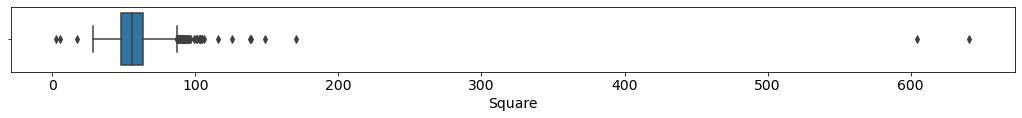

Square, Rooms=3


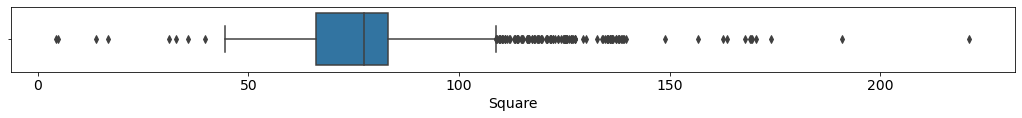

Square, Rooms=4


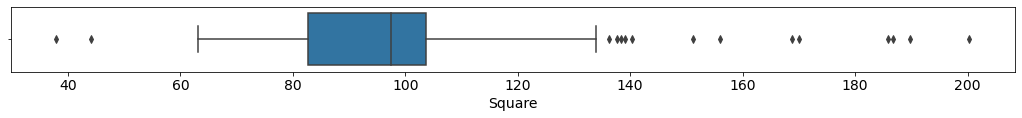

Square, Rooms=5


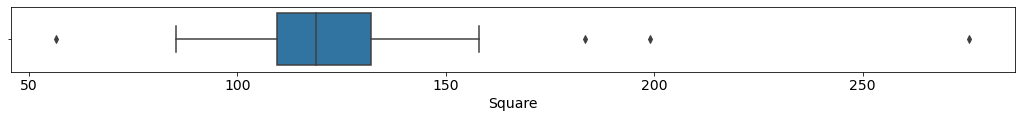

LifeSquare, Rooms=1


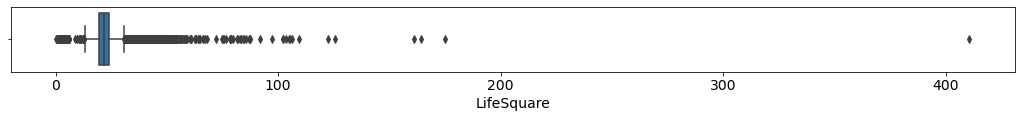

LifeSquare, Rooms=2


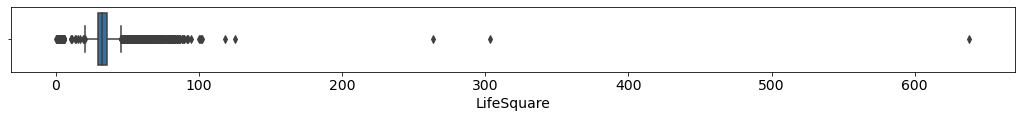

LifeSquare, Rooms=3


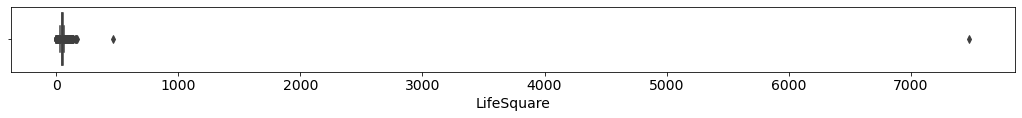

LifeSquare, Rooms=4


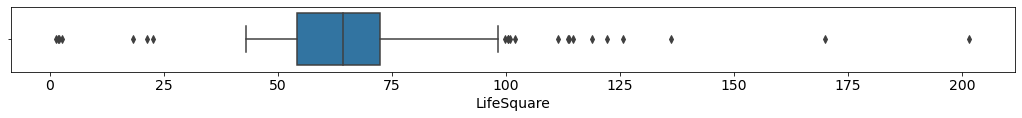

LifeSquare, Rooms=5


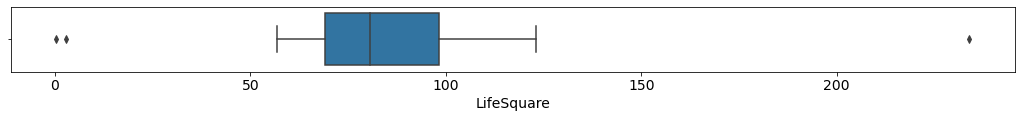

KitchenSquare, Rooms=1


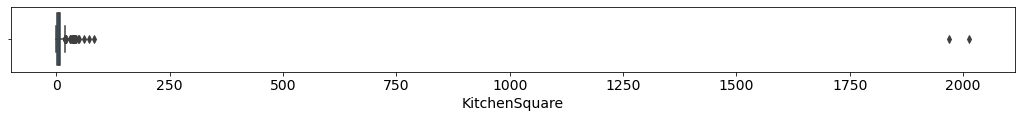

KitchenSquare, Rooms=2


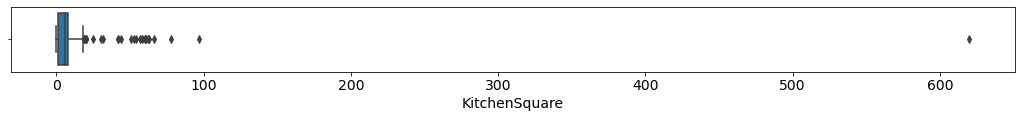

KitchenSquare, Rooms=3


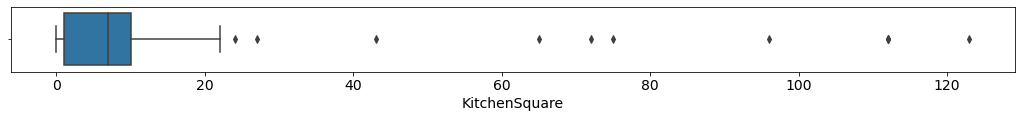

KitchenSquare, Rooms=4


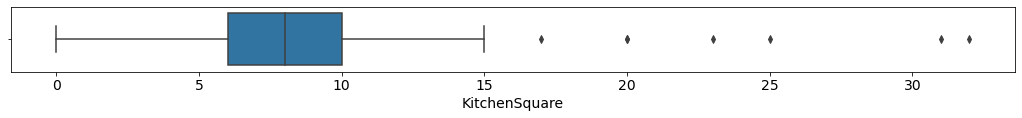

KitchenSquare, Rooms=5


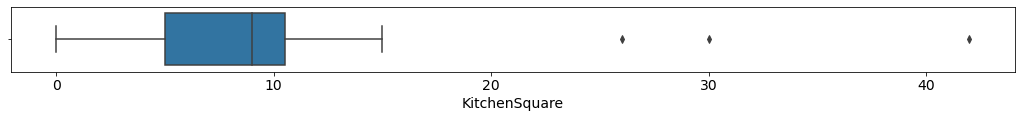

In [23]:
for square in ('Square', 'LifeSquare', 'KitchenSquare'):
    for room in range(1, 6):
        print(f'{square}, Rooms={room}')
        plt.figure(figsize=(18, 1.2))
        sns.boxplot(data=df_all.query('Rooms == @room'), x=square)
        plt.show()

Нужно избавляться от выбросов площадей квартиры, жилой и кухни.

In [24]:
# посмотрим на миниальные площади 
df_all.sort_values('Square').head(25)[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio
Id,,,,,,,,,,,,,,
14786,1,1,1.136859,4.525736,1,-4.388877,3,1,1977,181434.825589,1,1,1.136859,4.525736
9011,53,1,1.378543,1.353573,1,-0.975030,1,1,1977,NaN,0,1,1.378543,1.353573
1420,45,1,1.975769,2.900371,1,-1.924602,1,1,1977,NaN,0,1,1.975769,2.900371
15744,34,1,1.988943,2.642219,1,-1.653276,21,4,1977,458378.777006,1,1,1.988943,2.642219
1165,27,1,2.372101,1.899119,1,-0.527019,2,17,1977,NaN,0,1,2.372101,1.899119
3224,27,1,2.377248,0.873147,0,1.504101,1,0,1977,126596.941798,1,1,inf,inf
10202,6,1,2.596351,4.604943,1,-3.008592,3,25,2014,137597.601458,1,1,2.596351,4.604943
16401,30,1,2.645046,4.338755,1,-2.693709,2,1,1977,NaN,0,1,2.645046,4.338755
170,6,2,2.900586,61.468563,1,-59.567977,18,17,2014,NaN,0,1,2.900586,30.734282


Видим, что адекватная площадь, начинается с 13.3, все что меньше заполним средними значением по количеству комнат, району и году постройки дома и перед этим нужно поменять местами значения Square и LifeSquare.

In [25]:
# посмотрим на максимальные площади 
df_all.sort_values('Square', ascending=False).head(10)[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio
Id,,,,,,,,,,,,,,
11602,30,2,641.065193,638.163193,10,-7.098001,20,19,2019,133529.681562,1,1,64.106519,319.081597
28,9,2,604.705972,NaN,1,NaN,17,18,1977,187717.242538,1,1,604.705972,NaN
2307,102,1,409.425181,410.639749,10,-11.214568,4,4,2016,90470.430830,1,1,40.942518,410.639749
5548,86,5,275.645284,233.949309,26,15.695975,12,37,2011,455264.882666,1,1,10.601742,46.789862
4058,27,6,223.453689,104.113552,16,103.340136,2,2,2017,NaN,0,1,13.965856,17.352259
1397,76,3,221.138768,118.055342,4,99.083426,32,48,2011,NaN,0,1,55.284692,39.351781
7917,27,6,212.932361,211.231125,0,1.701236,2,3,2008,302211.260887,1,1,inf,inf
16568,27,4,200.334539,201.627361,25,-26.292822,1,2,2013,528560.506016,1,1,8.013382,50.406840
4249,23,5,198.930182,123.139863,10,65.790319,1,2,2011,345665.209100,1,1,19.893018,24.627973


Видим, что адекватная площадь, меньше 276, все что больше заполним средними значением по количеству комнат, району и году постройки дома

In [26]:
# посмотрим на максимальные площади LifeSquare
df_all.sort_values('LifeSquare', ascending=False).head(10)[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio
Id,,,,,,,,,,,,,,
16550,27,3,81.694417,7480.592129,1,-7399.897712,9,17,2016,217357.492366,1,1,81.694417,2493.530710
11602,30,2,641.065193,638.163193,10,-7.098001,20,19,2019,133529.681562,1,1,64.106519,319.081597
15886,85,3,78.059331,461.463614,10,-393.404284,12,16,1998,394253.299978,1,1,7.805933,153.821205
2307,102,1,409.425181,410.639749,10,-11.214568,4,4,2016,90470.430830,1,1,40.942518,410.639749
11533,94,2,48.713443,303.071094,6,-260.357651,5,12,1974,NaN,0,1,8.118907,151.535547
14990,23,2,48.449873,263.542020,5,-220.092147,6,5,1972,141780.231857,1,1,9.689975,131.771010
5548,86,5,275.645284,233.949309,26,15.695975,12,37,2011,455264.882666,1,1,10.601742,46.789862
7917,27,6,212.932361,211.231125,0,1.701236,2,3,2008,302211.260887,1,1,inf,inf
16568,27,4,200.334539,201.627361,25,-26.292822,1,2,2013,528560.506016,1,1,8.013382,50.406840


In [27]:
# Перед исправлением площадей посмотрим на значения Square и LifeSquare
df_all.query('Square < LifeSquare').sort_values('Square')[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio
Id,,,,,,,,,,,,,,
14786,1,1,1.136859,4.525736,1,-4.388877,3,1,1977,181434.825589,1,1,1.136859,4.525736
1420,45,1,1.975769,2.900371,1,-1.924602,1,1,1977,NaN,0,1,1.975769,2.900371
15744,34,1,1.988943,2.642219,1,-1.653276,21,4,1977,458378.777006,1,1,1.988943,2.642219
10202,6,1,2.596351,4.604943,1,-3.008592,3,25,2014,137597.601458,1,1,2.596351,4.604943
16401,30,1,2.645046,4.338755,1,-2.693709,2,1,1977,NaN,0,1,2.645046,4.338755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16053,17,4,168.729035,169.901701,0,-1.172667,4,0,2013,NaN,0,1,inf,42.475425
5300,30,3,169.509941,170.713651,1,-2.203710,2,2,2018,200800.673767,1,1,169.509941,56.904550
11055,151,1,174.649522,174.837082,15,-15.187560,10,12,1958,232766.187698,1,1,11.643301,174.837082


In [28]:
df_all.query('LifeSquare > Square * 1.2 or LifeSquare > 280').sort_values('Square')[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio
Id,,,,,,,,,,,,,,
14786,1,1,1.136859,4.525736,1,-4.388877,3,1,1977,181434.825589,1,1,1.136859,4.525736
1420,45,1,1.975769,2.900371,1,-1.924602,1,1,1977,NaN,0,1,1.975769,2.900371
15744,34,1,1.988943,2.642219,1,-1.653276,21,4,1977,458378.777006,1,1,1.988943,2.642219
10202,6,1,2.596351,4.604943,1,-3.008592,3,25,2014,137597.601458,1,1,2.596351,4.604943
16401,30,1,2.645046,4.338755,1,-2.693709,2,1,1977,NaN,0,1,2.645046,4.338755
170,6,2,2.900586,61.468563,1,-59.567977,18,17,2014,NaN,0,1,2.900586,30.734282
6782,45,1,2.954309,5.257278,1,-3.302970,3,1,1977,438005.182323,1,1,2.954309,5.257278
10527,27,1,4.380726,40.805837,1,-37.425111,10,17,2013,97560.720383,1,1,4.380726,40.805837
4504,27,3,4.390331,5.610772,1,-2.220441,8,19,2016,161379.067034,1,1,4.390331,1.870257


In [29]:
# присвоим значения LifeSquare = Square, если LifeSquare > Square * 2
# или если LifeSquare > Square * 1.2 и LifeSquare > 120
term1 = (df_all.LifeSquare > df_all.Square * 2)
term2 = ((df_all.LifeSquare > df_all.Square * 2) & (df_all.LifeSquare > 120))
idxes = df_all[term1 | term2].index
df_all.loc[idxes, 'LifeSquare'] = df_all.loc[idxes, 'Square'] - 0.1
df_all.loc[idxes, 'livesq_good'] = 0
# очистим LifeSquare если LifeSquare > 280
df_all.loc[df_all.LifeSquare > 280, 'livesq_good'] = 0
df_all.loc[df_all.LifeSquare > 280, 'LifeSquare'] = 0
# поменяем значения LifeSquare <-> Square, если LifeSquare > Square 
idxes = df_all[df_all.LifeSquare > df_all.Square].index
df_all.loc[idxes, ['Square', 'LifeSquare']] = df_all.loc[idxes, ['LifeSquare', 'Square']].values
df_all.loc[idxes, 'orig_both_sq'] = 0

In [30]:
df_all.loc[(df_all.Square < 13) | (df_all.Square > 280)].sort_values('Square')[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio
Id,,,,,,,,,,,,,,
14786,1,1,1.136859,1.036859,1,-4.388877,3,1,1977,181434.825589,1,1,1.136859,4.525736
9011,53,1,1.378543,1.353573,1,-0.975030,1,1,1977,NaN,0,1,1.378543,1.353573
1165,27,1,2.372101,1.899119,1,-0.527019,2,17,1977,NaN,0,1,2.372101,1.899119
3224,27,1,2.377248,0.873147,0,1.504101,1,0,1977,126596.941798,1,1,inf,inf
15744,34,1,2.642219,1.988943,1,-1.653276,21,4,1977,458378.777006,1,1,1.988943,2.642219
1420,45,1,2.900371,1.975769,1,-1.924602,1,1,1977,NaN,0,1,1.975769,2.900371
170,6,2,2.900586,2.800586,1,-59.567977,18,17,2014,NaN,0,1,2.900586,30.734282
16401,30,1,4.338755,2.645046,1,-2.693709,2,1,1977,NaN,0,1,2.645046,4.338755
10527,27,1,4.380726,4.280726,1,-37.425111,10,17,2013,97560.720383,1,1,4.380726,40.805837


In [31]:
# удаление выбросов Square
start_time = time.time()
df_all.loc[(df_all.Square < 13) | (df_all.Square > 280), 'square_good'] = 0
print('Выбросов по площади: ', len(df_all.query('square_good < 1')))
df_all['new_sq'] = df_all.apply(lambda row_x: fill_square(row_x, 'Square', 'square_good'), axis=1)
df_all['Square'] = df_all['new_sq']
df_all.drop(['new_sq'], axis=1, inplace=True)
print_time(start_time)

Выбросов по площади:  23
Время обработки: 0 час 0 мин 0.5 сек


In [32]:
# смотрим распределение по прощади кухни
for room in range(1, 7):
    kitchens = df_all.query('Rooms == @room').groupby(
        ['Rooms', 'KitchenSquare']).aggregate({'KitchenSquare': 'count',
                                               'Square': 'mean',
                                               'LifeSquare': 'mean'})
    
    kitchens.columns = ['count', 'Square', 'LifeSquare']
    kitchens['other_square'] = kitchens.Square - kitchens.LifeSquare
    print(kitchens.round(1))

                     count  Square  LifeSquare  other_square
Rooms KitchenSquare                                         
1     0                439    43.5        36.6           6.9
      1               1532    45.0        33.1          11.8
      2                  6    21.4        15.1           6.3
      3                 28    27.2        18.9           8.3
      4                 23    33.0        21.9          11.1
      5                508    33.9        21.3          12.7
      6                483    35.6        21.3          14.3
      7                386    38.7        21.5          17.2
      8                877    41.0        22.2          18.9
      9                513    39.4        21.7          17.7
      10               459    42.1        26.8          15.3
      11                69    47.3        23.9          23.5
      12                53    48.9        27.1          21.8
      13                30    49.2        22.8          26.4
      14                

Анализируя полученные данные по кухонной площади, следуют такие выводы: выбросами будем считать площадь кухни в квартирах с комнатами:1к < 3м, 2к < 4м, остальные < 5м. Так же выбросами будем считать если площадь кухни меньше оставшейся площади = Square - LifeSquare

В 6-ти комнатной квартире не может быть площадь 59.4, по медианному значению - это двухкомнатная квартира, исправим.

Так же вызывает подозрение 6-ти комнатная квартира с площадью 110, по медианному значению - это 5-тикомнатрая квартира, исправим.

Двух-трехкомнатные квартиры в общей площадью < 32 преобразуем в однокомнатные, 4х комнатные, с общей площадью < 50 преобразуем в двухкомнатные.

In [33]:
# исправление данных по шестикомнатной квартире на двухкомнатную
room_idx = df_all.query('Rooms == 6 and Square < 60').index
df_all.loc[room_idx, 'Rooms'] = 2
# исправление данных по шестикомнатной квартире на пятикомнатную
idxes = df_all.query('Rooms == 6 and Square < 120').index
room_idx.append(idxes)
df_all.loc[idxes, 'Rooms'] = 5
df_all.loc[room_idx, 'KitchenSquare'] = 10
df_all.loc[room_idx, 'kitchen_good'] = 0
# Оставшиеся шестикомнатные квартиры преобразуем в пятикомнатные
idxes = df_all.query('Rooms == 6').index
df_all.loc[idxes, 'Rooms'] = 5
room_idx.append(idxes)
# Двух-трехкомнатные квартиры в общей площадью < 32 преобразуем в однокомнатные
idxes = df_all.query('Rooms in (2, 3) and Square < 32').index
df_all.loc[idxes, 'Rooms'] = 1
room_idx.append(idxes)
# Трехкомнатные квартиры в общей площадью < 40 преобразуем в двухкомнатные
idxes = df_all.query('Rooms == 3 and Square < 40').index
df_all.loc[idxes, 'Rooms'] = 2
room_idx.append(idxes)
# 4х комнатные, с общей площадью < 50 преобразуем в двухкомнатные.
idxes = df_all.query('Rooms == 4 and Square < 50').index
df_all.loc[idxes, 'Rooms'] = 2
room_idx.append(idxes)
# 5ти комнатные, с общей площадью < 60 преобразуем в трехкомнатные.
idxes = df_all.query('Rooms == 5 and Square < 60').index
df_all.loc[idxes, 'Rooms'] = 3
room_idx.append(idxes)
df_all.loc[room_idx, 'rooms_good'] = 0
recalc_square()

In [34]:
start_time = time.time()
# отсутствующую жилую площадь будем заполнять средней площадью квартир
# из этого района, количества комнат и дома одного года постройки.
# Если не нашли дома по году, проделаем тоже самое без года
# удаление пропусков LifeSquare
df_all.loc[pd.isna(df_all.LifeSquare), 'livesq_nonan'] = 0
df_all['new_ls1'] = df_all.apply(lambda row_x: fill_square(row_x,
                                                           'LifeSquare',
                                                           'livesq_nonan'),
                                 axis=1)
# второй вариант
tmp = df_all[df_all.livesq_nonan > 0]
tmp_rooms = tmp.groupby(['DistrictId', 'Rooms'],
                        as_index=False).aggregate({'Square': 'mean',
                                                   'LifeSquare': 'mean'})
tmp_rooms.columns = ['DistrictId', 'Rooms', 'sq_mean', 'lq_mean']
# print(tmp_rooms.round(1))

# заполним отсутствующие жилую площадь по минимальной разнице площади
# квартиры и медианного значения площади в этом районе
df_all['new_ls2'] = df_all.LifeSquare
for idx in df_all[df_all.livesq_nonan < 1].index:
    id_dst = df_all.loc[idx, 'DistrictId']
    tmp_rooms['delta'] = abs(tmp_rooms.sq_mean - df_all.loc[idx, 'Square'])
    idx_tmp = tmp_rooms[tmp_rooms.DistrictId == id_dst]
    if not len(idx_tmp):
        idx_tmp = tmp_rooms
    idx_min = idx_tmp.delta.idxmin()
    df_all.loc[idx, 'new_ls2'] = tmp_rooms.loc[idx_min]['lq_mean']
    min_ls = df_all.loc[idx, ['new_ls1', 'new_ls2']].min()
    max_ls = df_all.loc[idx, ['new_ls1', 'new_ls2']].max()
    if max_ls <= df_all.loc[idx, 'Square'] * 0.8:
        df_all.loc[idx, 'LifeSquare'] = max_ls
    else:
        df_all.loc[idx, 'LifeSquare'] = min_ls

df_all.drop(['new_ls1', 'new_ls2'], axis=1, inplace=True)
recalc_square()
print_time(start_time)

Время обработки: 0 час 0 мин 17.7 сек


In [35]:
#  выбросами будем считать площадь кухни в квартирах с комнатами:
#  1к < 3м, 2к < 4м, остальные < 5м.
#  Так же выбросами будем считать если площадь кухни меньше
#  оставшейся площади = Square - LifeSquare
df_all['kt_ratio'] = df_all.Square / df_all.KitchenSquare
rooms_cond = [(df_all.Rooms == 1), (df_all.Rooms == 2), (df_all.Rooms >= 3)]
ksq, k_rat = (3, 4, 5), (2.3, 2.4, 3.2) 
for idx, cnd in enumerate(rooms_cond):
    df_all.loc[cnd & (df_all.KitchenSquare < ksq[idx]), 'kitchen_good'] = 0
    df_all.loc[cnd & (df_all.kt_ratio < k_rat[idx]), 'kitchen_good'] = 0
print(f"Неверная площадь кухни в "
      f"{len(df_all[df_all.kitchen_good < 1]) / len(df_all):.1%} данных")

Неверная площадь кухни в 31.7% данных


In [36]:
# площадь кухни будем заполнять по медианной площади кухни у квартир
# из этого района, количества комнат и дома одного года постройки.
# Если не нашли дома по году, проделаем тоже самое без года
# удаление выбросов KitchenSquare
start_time = time.time()
df_all['new_ks'] = df_all.apply(lambda row_x: fill_square(row_x,
                                                          'KitchenSquare',
                                                          'kitchen_good'),
                                axis=1)
df_all['KitchenSquare'] = df_all['new_ks']
df_all.drop(['new_ks'], axis=1, inplace=True)
recalc_square()
print_time(start_time)

Время обработки: 0 час 0 мин 13.7 сек


In [37]:
# обнаружены косяки с площадями: кухня сильно большая: 
# есть подозрение, что некоторые квартиры - это комнаты в коммуналках, судя по году
df_all[(df_all.Square < 28) & (df_all.other_sq <= 0)].sort_values('Square')[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio
Id,,,,,,,,,,,,,,
15435,21,1,13.305531,9.495367,8,-4.189836,6,5,1965,NaN,0,0,1.663191,9.495367
5480,190,1,15.948246,13.597819,8,-5.649572,2,5,1909,NaN,0,0,1.993531,13.597819
12676,81,1,15.988889,13.784865,8,-5.795975,4,5,1960,78388.806186,1,0,1.998611,13.784865
6927,21,1,16.117154,8.822988,8,-0.705834,2,5,1965,79913.267856,1,0,2.014644,8.822988
7533,66,1,16.319015,11.118981,8,-2.799966,4,5,1965,NaN,0,0,2.039877,11.118981
15877,57,1,16.698571,16.547242,3,-2.848671,5,5,1962,77835.185808,1,0,5.566190,16.547242
9884,29,1,17.273699,16.452172,3,-2.178473,3,5,1962,NaN,0,0,5.757900,16.452172
15127,150,1,20.036232,17.046188,8,-5.009955,7,12,1982,74222.110465,1,1,2.504529,17.046188
15846,34,1,26.719723,26.719723,8,-8.000000,4,2,2015,NaN,0,0,3.339965,26.719723


In [38]:
# исправление косяков с площадями: пересчитаем площадь кухни
cond_other = (df_all.Square < 26) & (df_all.other_sq < 0)
df_all.loc[cond_other, 'KitchenSquare'] = df_all.loc[cond_other, 'Square'] - \
                                          df_all.loc[cond_other, 'LifeSquare']
# если площадь кухни стала = 0 поставим медианное значение
ks_null = (df_all.Square < 26) & (df_all.KitchenSquare < 1)
med_ks = df_all[(df_all.Square < 26) & (df_all.KitchenSquare > 0)].KitchenSquare.median()
df_all.loc[ks_null, 'KitchenSquare'] = med_ks
df_all.loc[ks_null, 'LifeSquare'] = df_all.loc[ks_null, 'LifeSquare'] - med_ks
df_all.KitchenSquare = df_all.KitchenSquare.astype(int)
recalc_square()

In [39]:
df_all[(df_all.Square < 26) & (df_all.other_sq < 0)].sort_values('Square')[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio
Id,,,,,,,,,,,,,,


В квартирах с площадью менее 26 кв.метров все хорошо, их больше не трогаем.

In [40]:
show_columns.extend(['livesq_good', 'livesq_nonan', 'kitchen_good'])

In [41]:
# тут явно нужно корректировать площадь кухни (большевата) на типичную для таких квартир
df_all[(df_all.Square < 30) & (df_all.other_sq < 0)].sort_values('Square')[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
15846,34,1,26.719723,26.719723,8,-8.000000,4,2,2015,NaN,0,0,3.339965,26.719723,1,0,0
5210,27,1,27.245731,27.245731,10,-10.000000,8,16,2016,74982.605917,1,0,2.724573,27.245731,1,0,0
3538,23,1,27.730287,27.293799,10,-9.563512,9,17,2016,75695.826241,1,1,2.773029,27.293799,1,1,1
2950,23,1,27.778509,26.715238,10,-8.936729,5,4,2017,60918.567890,1,0,2.777851,26.715238,1,1,0
16077,27,1,27.829022,23.196754,5,-0.367732,7,19,1977,79372.454117,1,0,5.565804,23.196754,1,0,0
15385,23,1,27.911197,27.603121,10,-9.691924,3,6,2017,65608.074129,1,0,2.791120,27.603121,1,1,0
5890,23,1,27.981848,27.598712,8,-7.616864,13,15,2015,62819.167655,1,1,3.497731,27.598712,1,1,1
16137,23,1,28.333221,26.438012,10,-8.104791,4,3,2017,66818.859922,1,0,2.833322,26.438012,1,1,0
1300,23,1,28.827565,28.444315,10,-9.616750,8,17,2016,73162.636079,1,1,2.882757,28.444315,1,1,1


In [42]:
# добавление составного поля из двух колонок для будущего индекса
df_all['rooms_intsq'] = df_all.Rooms.astype(str) + '_' + df_all.int_square.astype(str)
df_all['rooms_intsq'] = df_all['rooms_intsq'].astype('category')

In [43]:
# для проставления адекватной площади кухни сгруппируем данные по кол-ву комнат и целой площади
cond_grp = (df_all.other_sq > 0) | (df_all.kitchen_good > 0)
group_rooms = df_all[cond_grp].groupby(['Rooms', 'int_square'],
                                   as_index=False).agg({'learn': 'count',
                                                        'Square': ['median'],
                                                        'LifeSquare': ['median'],
                                                        'KitchenSquare': ['median'],
                                                        'other_sq': ['median']})
group_rooms.columns = ['Rooms', 'int_square', 'rcount', 'sq_median', 'lq_median', 
                       'ks_median', 'os_median']
group_rooms.ks_median = (group_rooms.ks_median + 0.1).round(0).astype(int)
group_rooms['rooms_intsq'] = group_rooms.Rooms.astype(str) + '_' + group_rooms.int_square.astype(str)
group_rooms['rooms_intsq'] = group_rooms['rooms_intsq'].astype('category')
group_rooms.round(1)

,Rooms,int_square,rcount,sq_median,lq_median,ks_median,os_median,rooms_intsq
0,1,13,1,13.3,9.5,3,0.8,1_13
1,1,16,4,16.1,12.4,4,0.2,1_16
2,1,17,4,17.3,13.4,3,0.9,1_17
3,1,18,1,18.1,9.7,3,5.5,1_18
4,1,19,4,19.0,14.4,3,1.7,1_19
...,...,...,...,...,...,...,...,...
355,5,158,1,158.0,101.0,12,44.9,5_158
356,5,183,1,183.4,101.0,15,67.4,5_183
357,5,199,1,198.9,123.1,10,65.8,5_199
358,5,223,1,223.5,104.1,16,103.3,5_223


In [44]:
# проверим все ли квартиры найдутся в группировке
inv_cond = ((df_all.other_sq <= 0) & (df_all.kitchen_good < 1))
no_found = df_all[inv_cond & ~df_all.rooms_intsq.isin(group_rooms.rooms_intsq)].sort_values(['Rooms', 'Square'])
no_found[['rooms_intsq','int_square'] + show_columns]

,rooms_intsq,int_square,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,,,
11424,1_89,89,27,1,88.627115,79.588914,29,-19.961799,1,3,2014,NaN,0,0,3.056107,79.588914,1,1,0
16274,1_105,105,113,1,104.926922,103.763434,8,-6.836512,21,20,2014,NaN,0,0,13.115865,103.763434,1,1,0
9021,1_105,105,23,1,105.338395,103.744170,8,-6.405775,26,25,1977,223249.331500,1,0,13.167299,103.744170,1,1,0
1153,2_102,102,17,2,102.024454,100.751999,17,-15.727545,12,21,2015,560453.414813,1,0,6.001438,50.375999,1,1,0
1392,3_42,42,30,3,41.832097,39.596076,6,-3.763979,2,5,1977,147861.195616,1,0,6.972016,13.198692,1,1,0
14181,3_157,157,62,3,156.636577,153.685835,9,-6.049259,1,3,2005,502523.573863,1,0,17.404064,51.228612,1,1,0
2603,3_165,165,30,3,164.526757,162.587886,12,-10.061129,2,3,1977,207407.352593,1,0,13.710563,54.195962,1,1,0
5300,3_171,171,30,3,170.713651,169.509941,9,-7.796290,2,2,2018,200800.673767,1,0,18.968183,56.503314,1,1,0
5533,4_111,111,23,4,111.455258,110.621223,13,-12.165966,4,3,2015,206796.670741,1,0,8.573481,27.655306,1,1,0


Видим, что не все данные есть в группировке. Добавим в группировку строки из этой таблицы для отсутствующих значений int_square с группировкой по диапазону Square +/- 10%.

In [45]:
for idx in no_found.index:
    rooms = no_found.loc[idx, 'Rooms']
    square = no_found.loc[idx, 'Square']
    int_square = no_found.loc[idx, 'int_square']
    if square <= 50:
        koefic = 0.1
    elif square < 150:
        koefic = 0.05
    else:
        koefic = 0.2
    min_sq = square * (1 - koefic)
    max_sq = square * (1 + koefic)

    tmp = df_all[(df_all['Rooms'] == rooms) & (df_all['Square'] > min_sq) & 
                 (df_all['Square'] < max_sq)]
    print(rooms, square, len(tmp))
    idx_rooms_intsq = f'{rooms}_{int_square}'
    if idx_rooms_intsq not in group_rooms.rooms_intsq.values:
        group_rooms.loc[len(group_rooms)] = [rooms, int_square, 1,
                                             tmp.Square.median(),
                                             tmp.LifeSquare.median(),
                                             tmp.KitchenSquare.median(),
                                             tmp.other_sq.median(),
                                             idx_rooms_intsq]
group_rooms.ks_median = (group_rooms.ks_median + 0.1).round(0).astype(int)

1 88.62711549813555 7
1 104.9269218097437 14
1 105.33839518269023 14
2 102.02445368248405 10
3 41.83209727487336 6
3 156.6365765223595 51
3 164.52675714295378 37
3 170.71365082444072 23
4 111.45525750343643 18
4 113.83042528173088 17
5 120.33072670890957 8
5 212.9323610463113 4


In [46]:
# для этих строк нужно заменить KitchenSquare
cond_ks = (df_all.Square > 26) & (df_all.other_sq <= 0) & (df_all.kitchen_good < 1)
df_all[cond_ks].sort_values('Square')[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
15846,34,1,26.719723,26.719723,8,-8.000000,4,2,2015,NaN,0,0,3.339965,26.719723,1,0,0
5210,27,1,27.245731,27.245731,10,-10.000000,8,16,2016,74982.605917,1,0,2.724573,27.245731,1,0,0
2950,23,1,27.778509,26.715238,10,-8.936729,5,4,2017,60918.567890,1,0,2.777851,26.715238,1,1,0
16077,27,1,27.829022,23.196754,5,-0.367732,7,19,1977,79372.454117,1,0,5.565804,23.196754,1,0,0
15385,23,1,27.911197,27.603121,10,-9.691924,3,6,2017,65608.074129,1,0,2.791120,27.603121,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,23,1,163.286965,161.155275,8,-5.868310,4,3,1977,228572.520347,1,0,20.410871,161.155275,1,1,0
2603,30,3,164.526757,162.587886,12,-10.061129,2,3,1977,207407.352593,1,0,13.710563,54.195962,1,1,0
16053,17,4,169.901701,168.729035,9,-7.827333,4,0,2013,NaN,0,0,18.877967,42.182259,1,1,0


In [47]:
# установка нового индекса
group_rooms = group_rooms.set_index('rooms_intsq')
group_rooms

,Rooms,int_square,rcount,sq_median,lq_median,ks_median,os_median
rooms_intsq,,,,,,,
1_13,1,13,1,13.305531,9.495367,3,0.810164
1_16,1,16,4,16.053022,12.358400,4,0.249095
1_17,1,17,4,17.343940,13.449358,3,0.936763
1_18,1,18,1,18.149267,9.698766,3,5.450501
1_19,1,19,4,19.013928,14.403159,3,1.702199
...,...,...,...,...,...,...,...
3_171,3,171,1,139.708806,81.122369,15,60.313556
4_111,4,111,1,110.910872,71.373972,11,30.372235
4_114,4,114,1,115.734780,73.217252,11,30.475195


In [48]:
# получение вышеизложенной группировки через функцию
cond_grp = (df_all.other_sq > 0) | (df_all.kitchen_good > 0)
inv_cond = ((df_all.other_sq <= 0) & (df_all.kitchen_good < 1))
group_rooms = make_grp_df(cond_grp, inv_cond)
group_rooms

,Rooms,int_square,lq_median,ks_median,hf_median,hy_mode
rooms_intsq,,,,,,
1_13,1,13,9.495367,3,5,1965
1_16,1,16,12.358400,4,5,1965
1_17,1,17,13.449358,3,5,1962
1_18,1,18,9.698766,3,5,1967
1_19,1,19,14.403159,3,5,1970
...,...,...,...,...,...,...
3_171,3,171,81.122369,15,3,1977
4_111,4,111,71.373972,11,22,2006
4_114,4,114,73.217252,11,17,2006


In [49]:
# установка KitchenSquare для (Square > 26) & (other_sq <= 0) & (kitchen_good < 1)
start_time = time.time()
cond_ks = (df_all.Square > 26) & inv_cond
for idx in df_all[cond_ks].index:
    rooms_intsq = df_all.loc[idx, 'rooms_intsq']
    df_all.loc[idx, 'KitchenSquare'] = group_rooms.loc[rooms_intsq, 'ks_median']
recalc_square()    
print_time(start_time)

Время обработки: 0 час 0 мин 0.7 сек


Нужно привести LifeSquare в соответствие с Square и KitchenSquare: other_sq = Square - LifeSquare - KitchenSquare, для other_sq < 0 и rm_ratio < 10 (или другого значения).

In [50]:
df_all[df_all.other_sq <= 0][show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
2352,1,1,40.409907,33.043023,8,-0.633116,10,22,1977,168106.007630,1,0,5.051238,33.043023,1,0,0
9951,1,1,46.887892,44.628132,10,-7.740240,12,20,1977,160400.401732,1,0,4.688789,44.628132,1,1,0
8094,6,3,79.867477,75.085125,10,-5.217649,3,17,2014,194756.023945,1,0,7.986748,25.028375,1,1,0
367,45,1,42.367289,40.012529,8,-5.645240,16,14,2015,250466.980777,1,0,5.295911,40.012529,1,1,0
847,74,2,74.131261,73.314975,11,-10.183714,7,6,1977,254005.381863,1,0,6.739206,36.657488,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14793,27,1,47.295978,45.000047,10,-7.704069,6,5,2017,NaN,0,1,4.729598,45.000047,1,1,1
4821,74,2,82.585069,82.542507,12,-11.957438,4,17,2015,NaN,0,0,6.882089,41.271253,1,1,0
9519,62,3,81.912997,75.872094,11,-4.959097,3,6,2015,NaN,0,1,7.446636,25.290698,1,1,1


In [51]:
df_all.sort_values('rm_ratio')[show_columns].head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
11602,30,2,56.651831,0.000000,10,46.651831,20,19,2019,133529.681562,1,1,5.665183,0.000000,0,1,1
2307,102,1,41.326801,0.000000,10,31.326801,4,4,2016,90470.430830,1,1,4.132680,0.000000,0,1,1
6553,34,5,122.375273,0.333490,9,113.041783,9,0,1977,NaN,0,0,13.597253,0.066698,1,1,0
4378,27,3,106.958871,0.641822,15,91.317049,17,0,2018,337299.867936,1,0,7.130591,0.213941,1,1,0
6406,27,2,66.469510,0.567267,10,55.902243,4,0,2018,NaN,0,0,6.646951,0.283633,1,1,0
13014,53,3,81.141636,0.863989,12,68.277648,10,1,2017,NaN,0,0,6.761803,0.287996,1,1,0
11829,34,4,98.047744,1.451846,10,86.595898,16,1,1977,366655.111294,1,0,9.804774,0.362961,1,1,0
13491,0,1,38.178277,0.370619,10,27.807658,19,17,2016,105134.286994,1,0,3.817828,0.370619,1,1,0
5112,6,2,63.591740,0.795539,10,52.796200,17,17,2014,174741.998061,1,1,6.359174,0.397770,1,1,1


Из этой таблицы видно, что есть выбросы по LifeSquare: слишком маленькое значение. Посмотрим на распределение rm_ratio в зависимости от количества комнат.

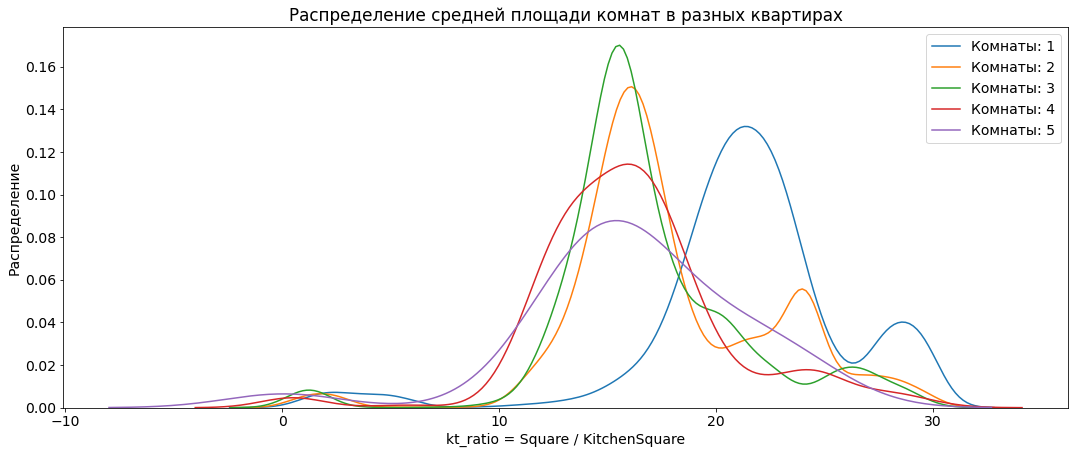

In [52]:
# посмотрим на распределение средней площади комнат в разных квартирах,
# точнее на параметр kt_ratio = Square / KitchenSquare
condition = (df_all.rm_ratio > 0) & (df_all.rm_ratio < 30)
legends = []
fig, ax = plt.subplots(figsize=(18, 7))
for rooms in range(1, 6):
    sns.kdeplot(df_all[(df_all.Rooms == rooms) & condition]['rm_ratio'], ax=ax)
    legends.append(f'Комнаты: {rooms}')
ax.set_title(u'Распределение средней площади комнат в разных квартирах')
ax.set_xlabel('kt_ratio = Square / KitchenSquare')
ax.set_ylabel('Распределение')
ax.legend(legends)
plt.show()

Видно, что менее 10 кв.метров начается отсечка, посмотрим подробнее.

Количество комнат: 1


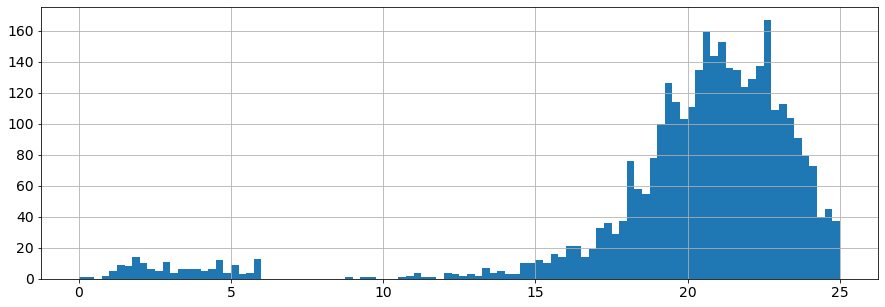

Количество комнат: 2


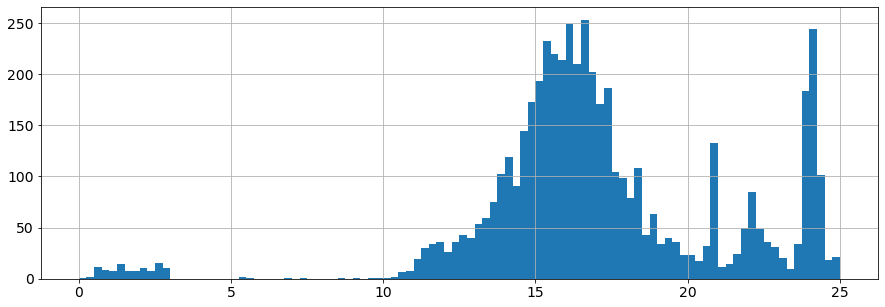

Количество комнат: 3


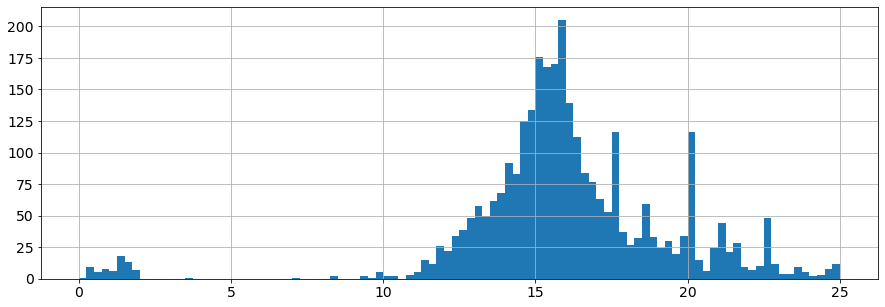

Количество комнат: 4


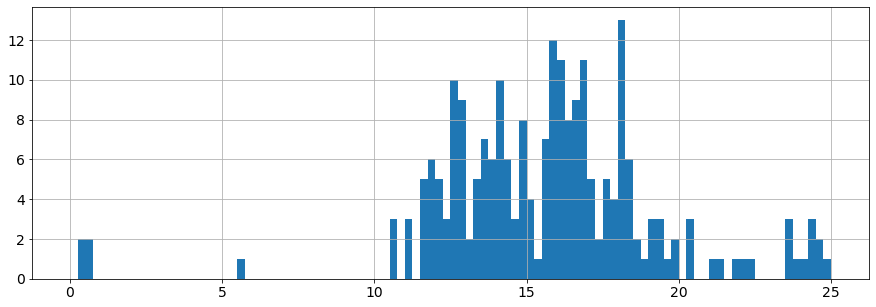

Количество комнат: 5


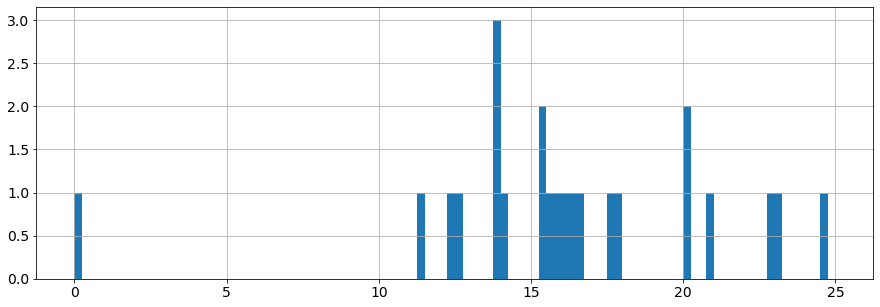

In [53]:
for rooms in range(1, 6):
    print(f'Количество комнат: {rooms}')
    df_all[(df_all.Rooms == rooms)]['rm_ratio'].hist(bins=100, range=(0,25), figsize=(15,5))
    plt.show()

Видно, что адекватная площадь комнаты начинается с 10 кв.м. Посмотрим подробнее и установим, что порог начинается с 9.8 кв.м

In [54]:
df_all.query('Square>26 and rm_ratio>8 and rm_ratio<10').sort_values('rm_ratio', ascending=False)[show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
2748,143,3,46.388203,29.716007,5,11.672196,3,5,1962,255479.601949,1,1,9.277641,9.905336,1,1,1
1684,53,2,40.003558,19.734294,7,13.269264,2,17,2005,221404.053548,1,1,5.714794,9.867147,1,1,1
11388,27,3,46.923652,29.542668,9,8.380985,24,0,1977,149404.835436,1,0,5.213739,9.847556,1,0,0
3761,27,3,46.500341,29.542668,9,7.957674,9,25,1977,140929.992373,1,0,5.166705,9.847556,1,0,0
11041,27,3,47.120275,29.542668,9,8.577607,25,0,1977,184690.868376,1,0,5.235586,9.847556,1,0,0
14869,27,3,46.699360,29.542668,9,8.156693,23,25,1977,NaN,0,0,5.188818,9.847556,1,0,0
3799,123,2,47.234446,19.363580,6,21.870866,2,12,1980,153924.162352,1,1,7.872408,9.681790,1,1,1
16537,2,3,47.973056,28.525670,5,14.447386,5,5,1960,NaN,0,1,9.594611,9.508557,1,1,1
10131,141,3,53.368865,28.356335,6,19.012530,11,16,1970,NaN,0,1,8.894811,9.452112,1,1,1


In [55]:
# отметка, что средняя площадь комнаты менее допустимого порога
df_all.loc[(df_all.Square > 26) & (df_all.rm_ratio < 9.8), 'rm_ratio_good'] = 0
# Заполняем LifeSquare
start_time = time.time()
cond_grp = ((df_all.other_sq > 0) & (df_all.rm_ratio > 9.8))
inv_cond = ((df_all.other_sq <= 0) | (df_all.rm_ratio < 9.8))
group_rooms = make_grp_df(cond_grp, inv_cond)

# print(group_rooms.sort_values(['Rooms', 'int_square']))

cond_ks = (df_all.Square > 26) & inv_cond
for idx in df_all[cond_ks].index:
    rms_intsq = df_all.loc[idx, 'rooms_intsq']
    # print(rms_intsq)
    df_all.loc[idx, 'LifeSquare'] = group_rooms.loc[rms_intsq, 'lq_median']
recalc_square()
print_time(start_time)

Время обработки: 0 час 0 мин 1.1 сек


In [56]:
# смотрим на результаты
df_all[df_all.rm_ratio < 9.8][show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
6927,21,1,16.117154,8.822988,7,0.294166,2,5,1965,79913.267856,1,0,2.302451,8.822988,1,1,0
15435,21,1,13.305531,9.495367,3,0.810164,6,5,1965,NaN,0,0,4.435177,9.495367,1,1,0
3969,101,1,18.149267,9.698766,3,5.450501,4,5,1967,NaN,0,1,6.049756,9.698766,1,1,1


Со средней площадью комнат порядок.

In [57]:
# остались кривые записи
df_all[df_all.other_sq <= 0][show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
16504,27,1,72.486741,52.620651,20,-0.133910,6,6,2017,195520.319385,1,1,3.624337,52.620651,1,1,1
10322,27,2,125.590534,125.306808,12,-11.716275,4,5,1977,164845.782727,1,1,10.465878,62.653404,1,1,1
3431,62,2,60.715426,37.551349,25,-1.835923,5,12,2012,172366.012197,1,1,2.428617,18.775675,1,1,1
14341,27,2,118.355254,115.553129,12,-9.197875,5,6,1977,NaN,0,1,9.862938,57.776565,1,1,1


In [58]:
# посчитаем для этих записей LifeSquare = Square - KitchenSquare - other_sq
for k, cond_sq in enumerate([((df_all.Square > 58) & (df_all.Square < 75)),
                             ((df_all.Square > 110) & (df_all.Square < 130))]):
    for idx in df_all[(df_all.other_sq <= 0) & cond_sq].index:
        sq = df_all.loc[idx, 'Square']
        ks = df_all.loc[idx, 'KitchenSquare']
        mos = df_all[cond_sq]['other_sq'].mean()
        rms = df_all.loc[idx, 'Rooms']
        df_all.loc[idx, 'LifeSquare'] = sq - ks - mos / (rms - k)
recalc_square()        

In [59]:
# с площадями порядок
df_all[df_all.other_sq <= 0][show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,


In [60]:
# добавим колонку с ценой 1кв.метра
df_all['price_sqm'] = df_all.Price / df_all.Square

Смотрим на остальные признаки:

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

In [61]:
list_cols = ['Floor', 'HouseFloor', 'Ecology_1', 'Ecology_2', 'Ecology_3',
             'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']
for col in list_cols:
    print(f'Признак: {col} - уникальных значений: {df_all[col].value_counts().nunique()}')

Признак: Floor - уникальных значений: 30
Признак: HouseFloor - уникальных значений: 35
Признак: Ecology_1 - уникальных значений: 92
Признак: Ecology_2 - уникальных значений: 2
Признак: Ecology_3 - уникальных значений: 2
Признак: Social_1 - уникальных значений: 47
Признак: Social_2 - уникальных значений: 98
Признак: Social_3 - уникальных значений: 28
Признак: Helthcare_2 - уникальных значений: 7
Признак: Shops_1 - уникальных значений: 16
Признак: Shops_2 - уникальных значений: 2


Смотрим на 'Floor', 'HouseFloor'

In [62]:
df_all.Floor.sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 37, 38,
       42, 46, 78], dtype=int64)

In [63]:
df_all.HouseFloor.sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  36,  37,  38,  39,
        40,  44,  45,  47,  48,  99, 117])

In [64]:
# посмотрим на квартиры более 46 этажа
tmp = df_all[df_all.Floor > 46][show_columns]
tmp

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
15759,17,2,57.60187,37.744743,10,9.857127,78,22,1989,NaN,0,1,5.760187,18.872372,1,1,1


In [65]:
# посмотрим на квартиры в этом районе в домах с числом этажей >= 22
df_all[df_all.DistrictId.isin(tmp.DistrictId) & (df_all.HouseFloor >= 22)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,learn,kt_ratio,rm_ratio,other_sq,int_square,rooms_good,square_good,livesq_good,orig_both_sq,livesq_nonan,kitchen_good,other_sq_good,rm_ratio_good,house_fl_good,house_fl_nonan,house_hy_good,rooms_intsq,price_sqm
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12861,17,3,77.185065,48.879521,9,21,22,1988,0.000000,B,B,25,5027,4,1,1,B,505464.884430,1,8.576118,16.293174,19.305544,77,1,1,1,1,1,1,1,1,1,1,1,3_77,6548.739547
5658,17,3,75.276260,45.187294,11,19,27,2003,0.000000,B,B,18,3374,5,1,2,B,439468.028640,1,6.843296,15.062431,19.088965,75,1,1,1,1,1,0,1,1,1,1,1,3_75,5838.069405
15973,17,1,48.046957,20.424394,11,3,24,2011,0.093443,B,B,23,4635,5,2,4,B,293475.701642,1,4.367905,20.424394,16.622562,48,1,1,1,1,1,1,1,1,1,1,1,1_48,6108.101800
10500,17,3,78.564131,45.599219,11,8,24,2010,0.093443,B,B,23,4635,5,2,4,B,520238.705869,1,7.142194,15.199740,21.964912,79,1,1,1,1,1,1,1,1,1,1,1,3_79,6621.834876
12178,17,2,59.891143,34.836738,10,11,22,1986,0.000000,B,B,25,5027,4,1,1,B,423184.940051,1,5.989114,17.418369,15.054405,60,1,1,1,1,1,1,1,1,1,1,1,2_60,7065.901880
11597,17,3,77.130226,48.360527,9,24,25,2008,0.000000,B,B,18,3374,5,1,2,B,586061.678416,1,8.570025,16.120176,19.769699,77,1,1,1,1,1,1,1,1,1,1,1,3_77,7598.339961
16666,17,2,57.408061,32.517698,8,27,25,2002,0.000000,B,B,18,3374,5,1,2,B,NaN,0,7.176008,16.258849,16.890363,57,1,1,1,1,1,1,1,1,1,1,1,2_57,NaN
3517,17,1,44.736029,19.261717,10,15,24,2011,0.093443,B,B,23,4635,5,2,4,B,NaN,0,4.473603,19.261717,15.474313,45,1,1,1,1,1,1,1,1,1,1,1,1_45,NaN
15759,17,2,57.601870,37.744743,10,78,22,1989,0.000000,B,B,25,5027,4,1,1,B,NaN,0,5.760187,18.872372,9.857127,58,1,1,1,1,1,1,1,1,1,1,1,2_58,NaN


В этой квартире ошиблись номером этажа, вместо 18, написали 78, исправим.

In [66]:
df_all.loc[df_all.Floor == 78, 'Floor'] = 18

In [67]:
# посмотрим на дома более 48 этажей
tmp = df_all[(df_all['HouseFloor'] > 48)][show_columns]
tmp

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
9300,74,2,74.579809,53.555141,9,12.024668,5,99,1977,243329.912579,1,1,8.286645,26.777570,1,1,1
78,30,2,66.811789,45.611135,10,11.200654,8,117,1977,207248.370520,1,0,6.681179,22.805568,1,1,0
10806,5,1,51.944587,32.038923,10,9.905664,6,99,1977,296127.115515,1,0,5.194459,32.038923,1,1,0
15864,27,3,47.722835,36.105364,9,2.617471,18,99,1977,NaN,0,1,5.302537,12.035121,1,1,1


In [68]:
idx_cond = df_all[df_all.HouseFloor > 48].index
districts = set(tmp.DistrictId.to_list())
df_all[~df_all.index.isin(idx_cond) & df_all.DistrictId.isin(districts) & 
       (df_all.HouseFloor > 0) & (df_all.HouseYear == 1977)].groupby(['DistrictId'], as_index=False).agg({'HouseFloor': ['count', 'min', 'max', 'mean', 'median']})

DistrictId HouseFloor                          
                  count min max       mean median
0          5          9   1  25  11.444444     12
1         27        483   1  25  12.159420     15
2         30        190   1  25  14.942105     17
3         74         79   1  25  12.772152     17

Домов много и для заполнения верных этажей, используем групировку по квартирам с одинаковой площадью.

In [69]:
start_time = time.time()
grp_field = 'HouseFloor'
inv_cond = (df_all[grp_field] > 48) & (df_all.HouseYear == 1977)
idx_cond = df_all[inv_cond].index
id_rooms = df_all.loc[idx_cond, 'Rooms'].unique()
cond_grp = (df_all[grp_field] > 0) & (df_all[grp_field] <= 48) & \
           (df_all.HouseYear == 1977) & df_all.Rooms.isin(id_rooms) & \
           ~df_all.index.isin(idx_cond)
group_rooms = make_grp_df(cond_grp, inv_cond)
for idx in idx_cond:
    rms_intsq = df_all.loc[idx, 'rooms_intsq']
    df_all.loc[idx, grp_field] = group_rooms.loc[rms_intsq, 'hf_median']
    df_all.loc[idx, 'house_fl_good'] = 0
print_time(start_time)   

Время обработки: 0 час 0 мин 0.1 сек


In [70]:
df_all.loc[idx_cond][show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
9300,74,2,74.579809,53.555141,9,12.024668,5,9,1977,243329.912579,1,1,8.286645,26.777570,1,1,1
78,30,2,66.811789,45.611135,10,11.200654,8,17,1977,207248.370520,1,0,6.681179,22.805568,1,1,0
10806,5,1,51.944587,32.038923,10,9.905664,6,9,1977,296127.115515,1,0,5.194459,32.038923,1,1,0
15864,27,3,47.722835,36.105364,9,2.617471,18,25,1977,NaN,0,1,5.302537,12.035121,1,1,1


In [71]:
# пометим нулевую этажность домов
df_all.loc[df_all.HouseFloor < 1, 'house_fl_nonan'] = 0

Посмотрим на записи HouseFloor == 0

In [72]:
df_all[(df_all['HouseFloor'] == 0)][show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,
4717,27,1,44.203947,29.576094,10,4.627853,2,0,1977,135466.559958,1,0,4.420395,29.576094,1,0,0
12947,53,2,56.023342,36.839046,9,10.184296,14,0,1977,247074.564832,1,0,6.224816,18.419523,1,0,0
13146,74,1,46.449711,32.038923,10,4.410788,6,0,1977,168705.450148,1,0,4.644971,32.038923,1,0,0
12174,62,1,44.954880,28.655432,10,6.299448,8,0,1977,133773.301722,1,0,4.495488,28.655432,1,0,0
15661,45,3,81.094922,64.406206,10,6.688716,15,0,1977,442472.456032,1,0,8.109492,21.468735,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187,45,3,79.798209,64.406206,10,5.392003,17,0,1977,NaN,0,0,7.979821,21.468735,1,0,0
11475,27,1,53.263561,36.609221,6,10.654340,9,0,1977,NaN,0,0,8.877260,36.609221,1,0,0
13900,169,1,48.530248,35.319897,10,3.210350,8,0,1977,NaN,0,0,4.853025,35.319897,1,0,0


In [73]:
# Посмотрим на записи HouseFloor == 0
# заполним этажность медианным значением у аналогичных квартир
start_time = time.time()
grp_field = 'HouseFloor'
inv_cond = (df_all[grp_field] < 1)
idx_cond = df_all[inv_cond].index
cond_grp = (df_all[grp_field] > 0) & ~df_all.index.isin(idx_cond)
group_rooms = make_grp_df(cond_grp, inv_cond)
for idx in idx_cond:
    rms_intsq = df_all.loc[idx, 'rooms_intsq']
    df_all.loc[idx, grp_field] = group_rooms.loc[rms_intsq, 'hf_median']
    # если вдруг найденная этажность дома меньше нужной запишем часто 
    # используемое значение в этом районе
    if df_all.loc[idx, grp_field] < df_all.loc[idx, 'Floor']:
        district = df_all.loc[idx, 'DistrictId']
        square = df_all.loc[idx, 'Square'] * 0.6
        hfloor = df_all.loc[idx, grp_field]
        hf_median = df_all.loc[(df_all.Square > square) &
                               (df_all.HouseFloor >= hfloor) &
                               (df_all.DistrictId == district), 
                               'HouseFloor'].value_counts().index[0]        
        df_all.loc[idx, grp_field] = hf_median
print_time(start_time)

Время обработки: 0 час 0 мин 0.5 сек


In [74]:
df_all[(df_all['HouseFloor'] == 0)][show_columns]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,other_sq,Floor,HouseFloor,HouseYear,Price,learn,kitchen_good,kt_ratio,rm_ratio,livesq_good,livesq_nonan,kitchen_good
Id,,,,,,,,,,,,,,,,,


In [75]:
# посмотрим на записи HouseFloor < Floor (этажность дома меньше этажа квартиры)
df_all[df_all.HouseFloor < df_all.Floor]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,learn,kt_ratio,rm_ratio,other_sq,int_square,rooms_good,square_good,livesq_good,orig_both_sq,livesq_nonan,kitchen_good,other_sq_good,rm_ratio_good,house_fl_good,house_fl_nonan,house_hy_good,rooms_intsq,price_sqm
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1190,8,2,49.396000,28.299600,5,6,5,1962,0.458174,B,A,26,4439,1,1,5,B,186971.926566,1,9.879200,14.149800,16.096400,49,1,1,1,1,1,1,1,1,1,1,1,2_49,3785.163325
367,45,1,42.367289,22.828053,8,16,14,2015,0.195781,B,B,23,5212,6,3,2,B,250466.980777,1,5.295911,22.828053,11.539235,42,1,1,1,1,1,0,1,1,1,1,1,1_42,5911.801026
8471,20,3,75.611065,47.494621,8,11,9,1976,0.019509,B,B,37,7687,11,5,5,B,366916.246494,1,9.451383,15.831540,20.116443,76,1,1,1,1,1,1,1,1,1,1,1,3_76,4852.679276
4521,6,2,65.409965,41.994054,12,18,1,1977,0.243205,B,B,5,1564,0,0,0,B,191205.272608,1,5.450830,20.997027,11.415911,65,1,1,1,1,0,0,1,1,1,1,1,2_65,2923.182598
8553,88,3,83.262530,52.004490,10,13,1,1977,0.127376,B,B,43,8429,3,3,9,B,410883.892020,1,8.326253,17.334830,21.258039,83,1,1,1,1,1,0,1,0,1,1,1,3_83,4934.799515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4963,67,2,55.101369,33.968217,8,18,17,1989,0.100456,B,B,43,7227,0,1,6,A,NaN,0,6.887671,16.984109,13.133151,55,1,1,1,1,1,1,1,1,1,1,1,2_55,NaN
14793,27,1,47.295978,25.300592,10,6,5,2017,0.072158,B,B,2,629,1,0,0,A,NaN,0,4.729598,25.300592,11.995386,47,1,1,1,1,1,1,0,1,1,1,1,1_47,NaN
11709,63,1,51.872447,37.568797,9,23,22,2016,0.238617,B,B,26,3889,6,3,6,B,NaN,0,5.763605,37.568797,5.303650,52,1,1,1,1,0,0,1,1,1,1,1,1_52,NaN


In [76]:
# поменяем значения HouseFloor <-> Floor, если HouseFloor < Floor 
idxes = df_all[df_all.HouseFloor < df_all.Floor].index
df_all.loc[idxes, ['Floor', 'HouseFloor']] = df_all.loc[idxes, ['HouseFloor', 'Floor']].values
# пометим кривую этажность домов
df_all.loc[idxes, 'house_fl_good'] = 0

In [77]:
# проверим
df_all[df_all.HouseFloor < df_all.Floor]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,learn,kt_ratio,rm_ratio,other_sq,int_square,rooms_good,square_good,livesq_good,orig_both_sq,livesq_nonan,kitchen_good,other_sq_good,rm_ratio_good,house_fl_good,house_fl_nonan,house_hy_good,rooms_intsq,price_sqm
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


#### Посмотрим на распределение этажности зданий по годам

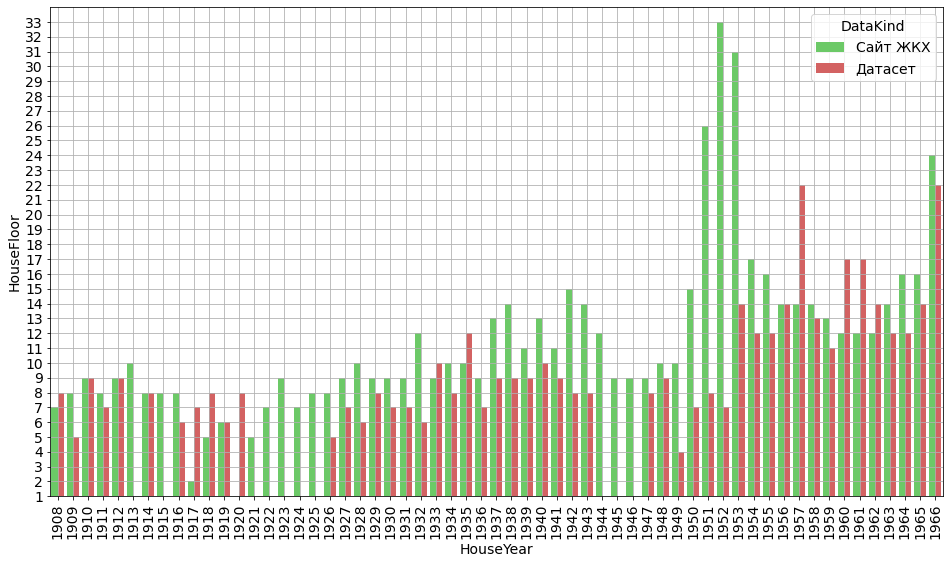

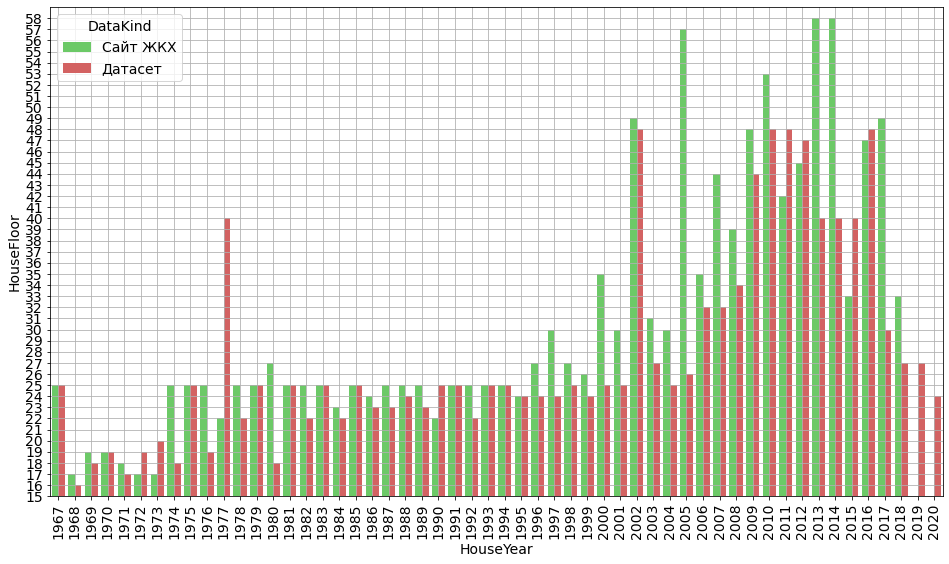

In [78]:
# Группировка данных для отображения максимальной этажности домов по годам
tmp_concat, tmp_merged = group_years(60)

# Посмотрим на распределение этажности зданий по годам датасета и сайта ЖКХ
list_years = sorted(tmp_concat.HouseYear.values)
div_years = list_years[len(list_years) // 2 + 1]
for num_part in (0, 1):
    year_query = f'HouseYear {["<", ">="][num_part]} {div_years}'
    y_min = tmp_concat.query(year_query).HouseFloor.min()
    y_max = tmp_concat.query(year_query).HouseFloor.max() + 1
    if y_min > 1:
        y_min -= 1
    fig, ax = plt.subplots(figsize=(16, 9))
    sns.set_color_codes("muted")
    sns.barplot(x='HouseYear', y='HouseFloor', hue='DataKind',
                hue_order=['Cайт ЖКХ', 'Датасет'], palette=['g', 'r'],
                saturation=.95, data=tmp_concat.query(year_query))
    ax.set_ylim(y_min, y_max)
    plt.yticks([y for y in range(y_min, y_max)])
    ax.grid()
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.show()

In [79]:
# расхождения между нашим датасетом и данными с сайта "Жилые дома Москвы"
tmp_merged = tmp_merged.query('HouseFloor - HouseFloor_MSK > 3 and '
                              'HouseYear > 1920 and HouseYear < 2000')
tmp_merged

,HouseYear,HouseFloor,HouseFloor_MSK
38,1957,22,14
41,1960,17,12
42,1961,17,12
58,1977,40,22


### Анализируя гистограммы - будем исправлять года домов по этой таблице.

In [80]:
tmp_merged[['HouseYear', 'HouseFloor_MSK']].to_dict('split')['data']

[[1957, 14], [1960, 12], [1961, 12], [1977, 22]]

In [81]:
start_time = time.time()
years_floors = tmp_merged[['HouseYear', 
                           'HouseFloor_MSK']].to_dict('split')['data']
grp_field = 'HouseYear'
for year, floors in years_floors:
    inv_cond = (df_all[grp_field] == year) & (df_all.HouseFloor - floors > 1)
    set_floors = sorted(df_all[inv_cond].HouseFloor.unique())
    print(f'Год: {year}, MAX этажность: {floors}, '
          f'количество квартир {len(df_all[inv_cond])}, Этажи: {set_floors}')
    for floor in set_floors:
        flr_cond = (df_all.HouseFloor == floor)
        inv_cond = (df_all[grp_field] == year) & flr_cond
        idx_cond = df_all[inv_cond].index
        cond_grp = (df_all[grp_field] != year) & flr_cond & \
                   ~df_all.index.isin(idx_cond)
        cond = (df_all[grp_field] != year) & ~df_all.index.isin(idx_cond)
        group_rooms = make_grp_df(cond_grp, inv_cond, cond, floor)
        for idx in idx_cond:
            rms_intsq = df_all.loc[idx, 'rooms_intsq']
            df_all.loc[idx, grp_field] = group_rooms.loc[rms_intsq, 'hy_mode']
            df_all.loc[idx, 'house_hy_good'] = 0
print_time(start_time)

Год: 1957, MAX этажность: 14, количество квартир 1, Этажи: [22]
Год: 1960, MAX этажность: 12, количество квартир 1, Этажи: [17]
Год: 1961, MAX этажность: 12, количество квартир 3, Этажи: [14, 17]
Год: 1977, MAX этажность: 22, количество квартир 391, Этажи: [24, 25, 26, 27, 28, 30, 31, 40]
Время обработки: 0 час 0 мин 1.2 сек


In [82]:
# сохранение измененных годов, чтобы прочитать в начале следующей итерации
columns_years = ['Floor', 'HouseFloor', 'HouseYear', 'house_fl_good',
                 'house_fl_nonan', 'house_hy_good']
changed_years = df_all[(df_all['house_hy_good'] < 1)][columns_years]
changed_years.to_csv(FILE_YEARS, sep=';')

Посмотрим на оставшиеся признаки

In [83]:
lst_cols = ['Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'DistrictId']
for col in lst_cols:
    print(f'Признак: {col} - уникальных значений: {df_all[col].value_counts().nunique()} {df_all[col].sort_values().unique()}')

Признак: Ecology_2 - уникальных значений: 2 ['A' 'B']
Признак: Ecology_3 - уникальных значений: 2 ['A' 'B']
Признак: Social_1 - уникальных значений: 47 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 46 47 49 50 52
 53 66 74]
Признак: Social_2 - уникальных значений: 98 [  168   186   264   290   342   362   388   469   475   507   528   568
   629   662   760   915  1135  1227  1318  1423  1437  1497  1564  1660
  1768  1892  1952  1986  2270  2277  2370  2398  2423  2514  2733  2738
  2748  2787  2810  2940  3079  3097  3151  3293  3369  3374  3379  3433
  3478  3594  3681  3684  3746  3806  3856  3889  3893  3975  4017  4048
  4231  4346  4378  4386  4439  4472  4583  4625  4635  4724  4756  4788
  4789  4798  4860  5011  5027  5048  5067  5148  5212  5261  5285  5288
  5469  5487  5562  5569  5613  5648  5664  5731  5735  5776  5889  5992
  6119  6137  6141  6149  6207  6398  6533  6558  6564  6566  6

Категориальные признаки - закодируем их соответственно категориям.

#### Посмотрим на связи признаков друг с другом и целевой переменной.

In [84]:
corr_columns = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'other_sq',
                'Floor', 'HouseFloor', 'HouseYear', 'kt_ratio', 'rm_ratio']

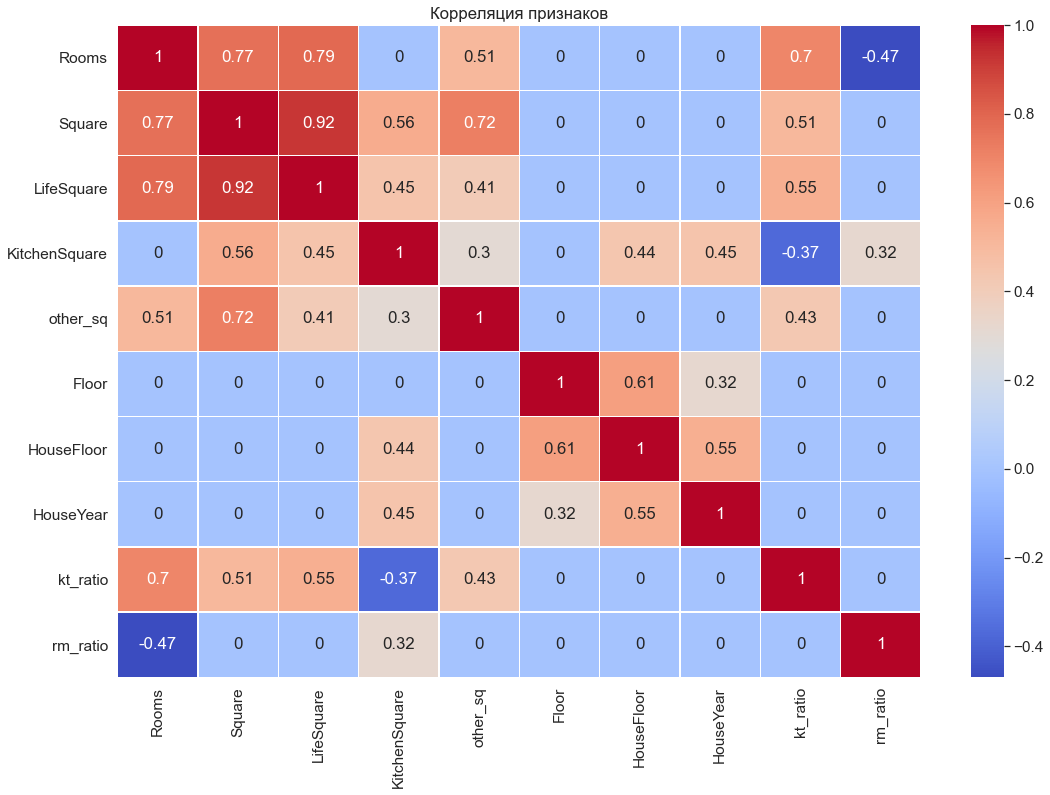

In [85]:
plt.figure(figsize=(18, 12))
sns.set(font_scale=1.4)
corr_matrix = df_all[corr_columns].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

Ожидаемо, что площади сильно связаны между собой, больше общая площадь - больше и остальные: жилая, площадь кухни и нежилая. Только на матрице корреляции увидел связь площади кухни от этажности дома и года постройки: чем новее дом - тем больше кухня и чем больше этажей - тем новее дом и больше кухня.

In [86]:
class NewFeatures():
    """Генерация новых фич"""

    def __init__(self):
        self.years_bins = [0, 3000]
        self.binary_to_numbers = None
        self.district_size = None
        self.med_district_price = None
        self.med_district_price_median = None
        self.med_year_floor_rooms_price = None
        self.med_year_rooms_price = None
        self.med_year_rooms_price_median = None

    def fit(self, df_in):
        df = df_in.copy(deep=True)

        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}

        # DistrictID
        self.district_size = df[
            'DistrictId'].value_counts().reset_index().rename(
            columns={'index': 'DistrictId', 'DistrictId': 'district_size'})

        # группировка по району и кол-ву комнат с медианной ценой квартиры
        # и медионной ценой квадратного метра
        self.med_district_price = df[df.learn == 1].groupby(
            ['DistrictId', 'Rooms'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_district_price',
                     'price_sqm': 'med_district_psqm'})
        self.med_district_price_median = self.med_district_price[
            ['med_district_price', 'med_district_psqm']].median()

        # поделим квартиры на категории в зависимости от года постройки дома
        # по эпохам строительства
        # https://strelkamag.com/ru/article/moscow-housing-map
        self.years_bins = [0, 1917, 1924, 1953, 1964, 1982, 1991, 2010,
                           df['HouseYear'].max()]

        # заполнение категории года дома
        df['year_cat'] = pd.cut(df.HouseYear, bins=self.years_bins,
                                labels=False)

        # группировка по категории года, этажу и комнатам с медианной ценой
        # и медионной ценой квадратного метра
        self.med_year_floor_rooms_price = df[df.learn == 1].groupby(
            ['year_cat', 'Floor', 'Rooms'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_year_floor_rooms_price',
                     'price_sqm': 'med_year_floor_rooms_psqm'})
        # группировка по категории года и комнатам с медианной ценой
        self.med_year_rooms_price = df[df.learn == 1].groupby(
            ['year_cat', 'Rooms'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_year_rooms_price',
                     'price_sqm': 'med_year_rooms_psqm'})
        self.med_year_rooms_price_median = self.med_year_rooms_price[
            ['med_year_rooms_price', 'med_year_rooms_psqm']].median()

    def transform(self, df_in):
        df = df_in.copy(deep=True)

        # кодировка категорийных признаков
        df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)
        df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)

        df['Id'] = df.index
        # заполнение размера района
        df = df.merge(self.district_size, on='DistrictId', how='left')
        df['district_size'].fillna(1, inplace=True)

        # заполнение средней цены по району
        if self.med_district_price is not None:
            df = df.merge(self.med_district_price, on=['DistrictId', 'Rooms'],
                          how='left')
            df.med_district_price.fillna(
                self.med_district_price_median['med_district_price'],
                inplace=True)
            df.med_district_psqm.fillna(
                self.med_district_price_median['med_district_psqm'],
                inplace=True)

        # заполнение категории года дома
        df['year_cat'] = pd.cut(df.HouseYear, bins=self.years_bins,
                                labels=False)

        # заполнение средней цены по категории года, кол-ву комнат
        if self.med_year_rooms_price is not None:
            df = df.merge(self.med_year_rooms_price,
                          on=['year_cat', 'Rooms'], how='left')
            df.med_year_rooms_price.fillna(
                self.med_year_rooms_price_median['med_year_rooms_price'],
                inplace=True)
            df.med_year_rooms_psqm.fillna(
                self.med_year_rooms_price_median['med_year_rooms_psqm'],
                inplace=True)

        # заполнение средней цены по категории года, этажу, кол-ву комнат
        if self.med_year_floor_rooms_price is not None:
            df = df.merge(self.med_year_floor_rooms_price,
                          on=['year_cat', 'Floor', 'Rooms'], how='left')
            # заполнение пропущенных значений с уровня группировки выше
            if self.med_year_rooms_price is not None:
                idx_nan_yfrp = df[pd.isna(df.med_year_floor_rooms_price)].index
                df.loc[idx_nan_yfrp, 'med_year_floor_rooms_price'] = df.loc[
                    idx_nan_yfrp, 'med_year_rooms_price']
                df.loc[idx_nan_yfrp, 'med_year_floor_rooms_psqm'] = df.loc[
                    idx_nan_yfrp, 'med_year_rooms_psqm']
        df = df.set_index('Id')
        return df        

In [87]:
new_features = NewFeatures()
new_features.fit(df_all)
df_all = new_features.transform(df_all)

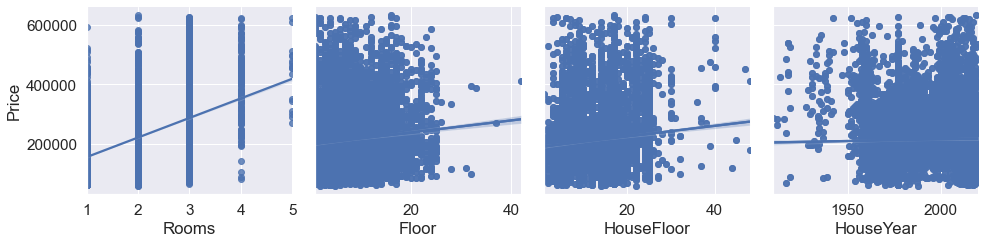

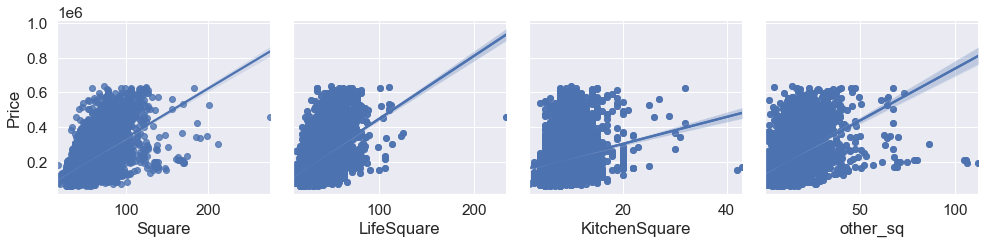

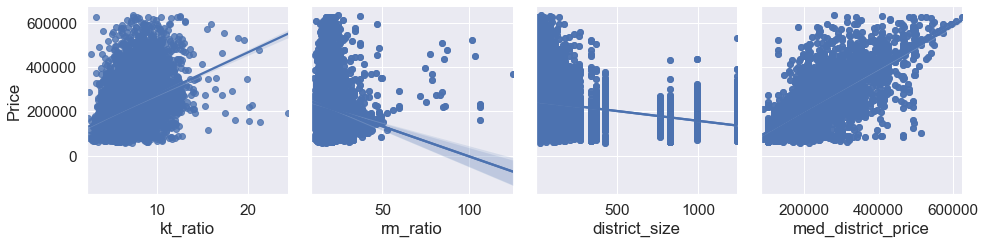

Время обработки: 0 час 0 мин 13.0 сек


In [88]:
scatter_params = ['Rooms', 'Floor', 'HouseFloor', 'HouseYear',
                  'Square', 'LifeSquare', 'KitchenSquare', 'other_sq',
                  'kt_ratio', 'rm_ratio', 'district_size', 'med_district_price',
                  'med_district_psqm', 'med_year_rooms_price']

start_time = time.time()
rows = len(scatter_params) // 4
if len(scatter_params) > 4:
    cols = 4
else:
    cols = len(scatter_params)
for row in range(rows):
    fig = sns.pairplot(df_all.query('learn == 1'), y_vars='Price',
                       x_vars=scatter_params[cols * row: cols * row + cols],
                       height=3.5, kind="reg")
    fig.map(sns.regplot)
    plt.show()
print_time(start_time) 

Ожидаемо, что стоимость квартиры зависит от количества комнат и площади. Есть слабая зависимость от этажа в многоэтажных домах. Слабая отрицательная зависимость от среднего размера комнат в квартире и размера района.

### Попробуем выполнить кластеризацию на основе исходных столбцов

In [89]:
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from pylab import rcParams

rcParams["figure.figsize"] = 18, 10

def display_clusters_distribution(labels_train):
    """Визуализация распределения классов по кластерам"""
    unique, counts = np.unique(labels_train, return_counts=True)
    fig = plt.figure()
    plt.bar(unique, counts)
    plt.yscale('log')
    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)
    fig = plt.figure()
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='comp_1', y='comp_2',
                                       c=components_with_labels_df.iloc[:, -1],
                                       cmap=plt.get_cmap('jet'),
                                       alpha=0.5)
    else:
        components_with_labels_df.plot(kind='scatter', x='comp_1', y='comp_2',
                                       alpha=0.5)
    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')
    plt.show()

In [90]:
tsne_columns = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
                'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
                'Shops_1', 'Shops_2']
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df_all[tsne_columns]),
                        columns=tsne_columns, index=df_all.index)

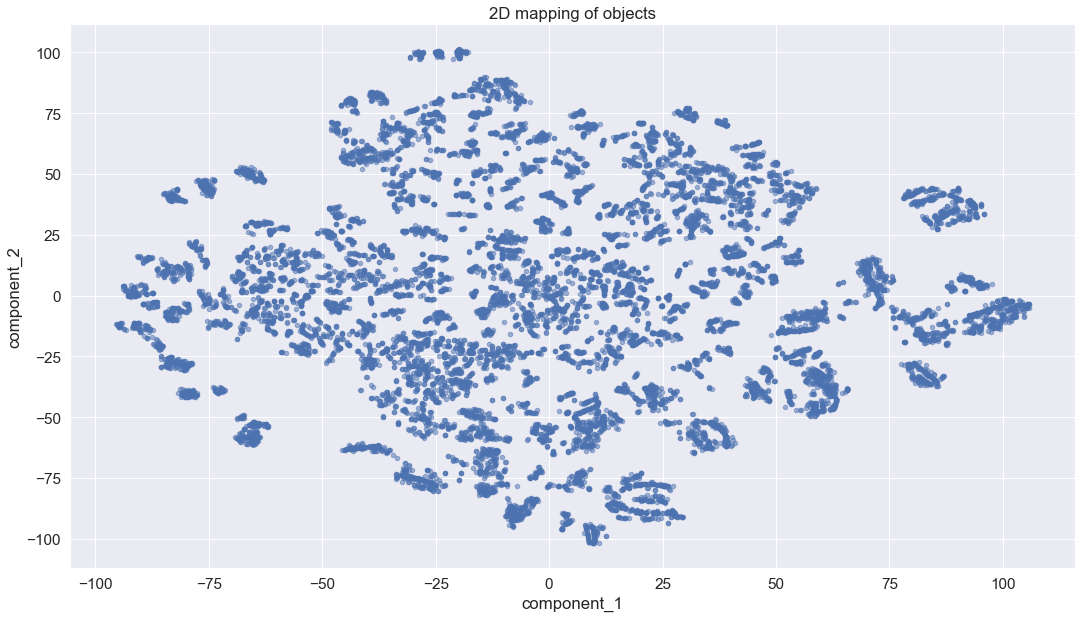

Wall time: 1min 54s

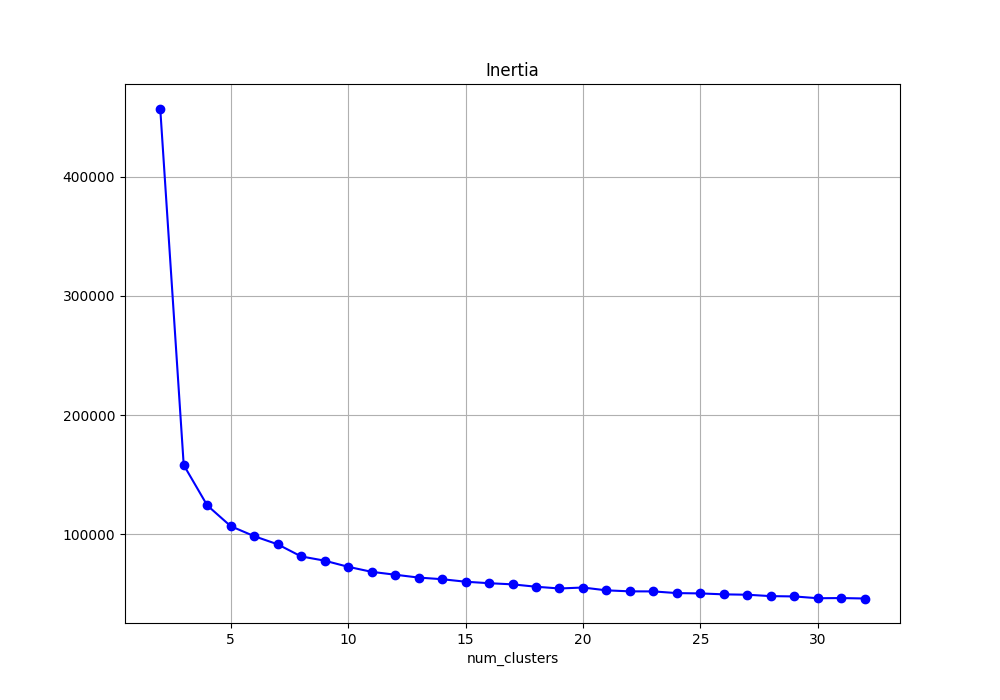

Inertia постепенно уменьшается к количуству кластеров 10-14, посмотрим картинку для 10 и 14 кластеров.

In [91]:
def show_tnse_kmeans(clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=2021)
    labels_train = kmeans.fit_predict(X_scaled)
    display_components_in_2D_space(df_tsne, labels_train)
    display_clusters_distribution(labels_train)
    
def show_tnse_aggl(clusters):
    aggl = AgglomerativeClustering(n_clusters=clusters)
    labels_train = aggl.fit_predict(X_scaled)
    display_components_in_2D_space(df_tsne, labels_train)
    display_clusters_distribution(labels_train)

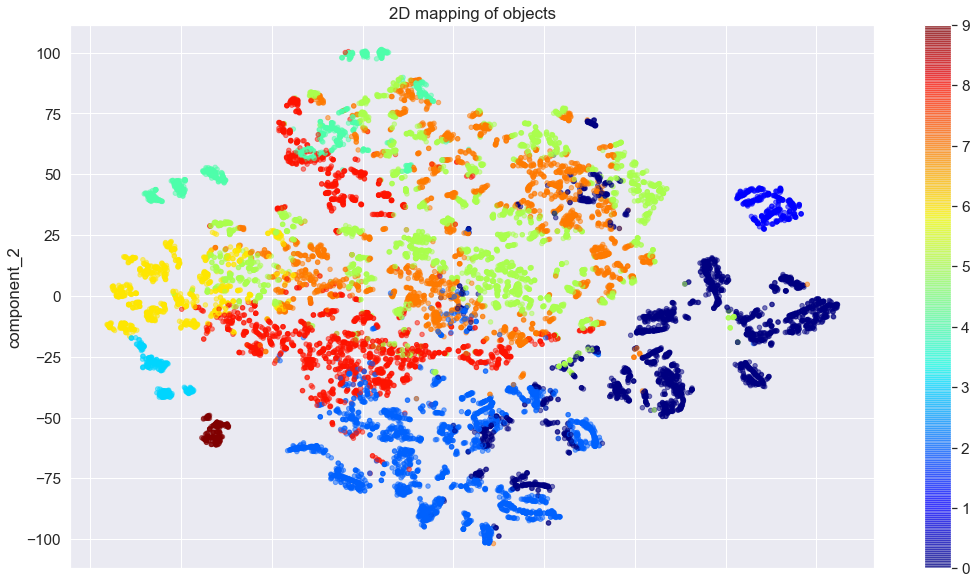

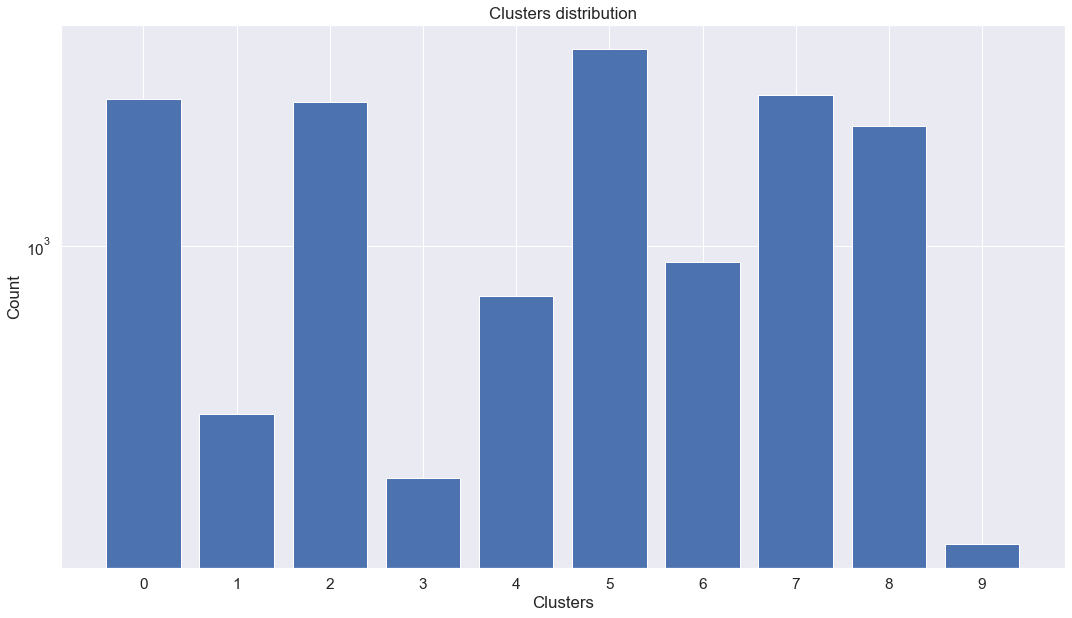

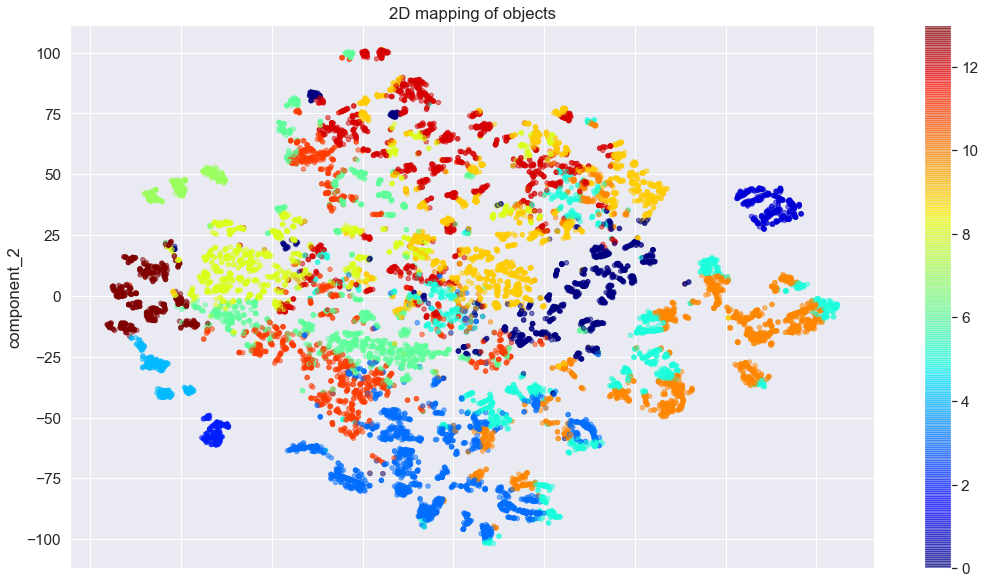

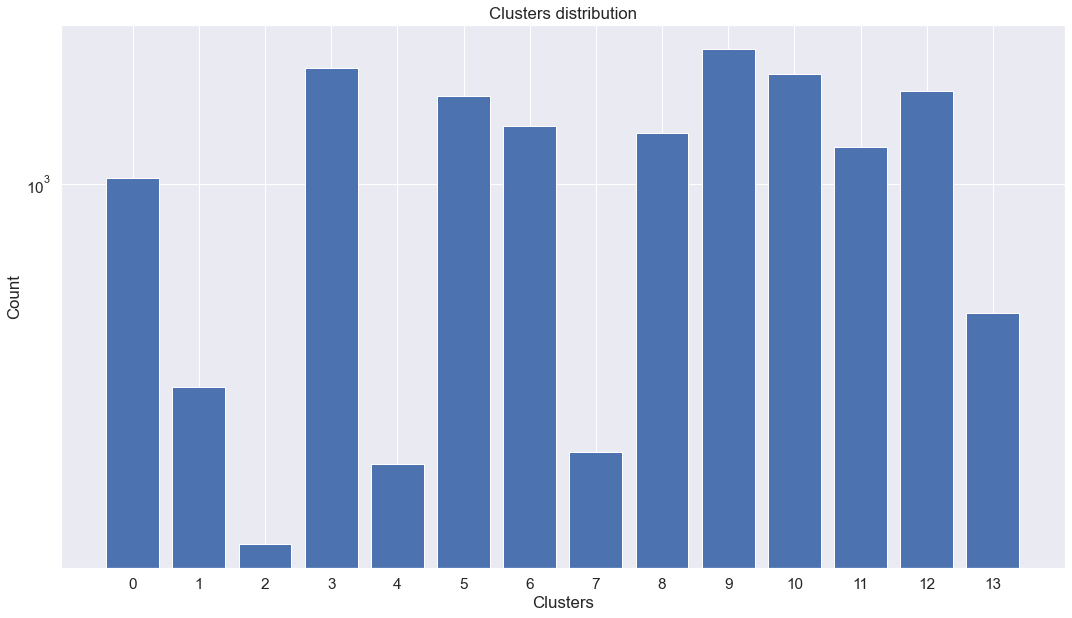

DBSCAN не получилось настроить, т.к. постоянно выделяет один большой кластер и несколько мелких. 

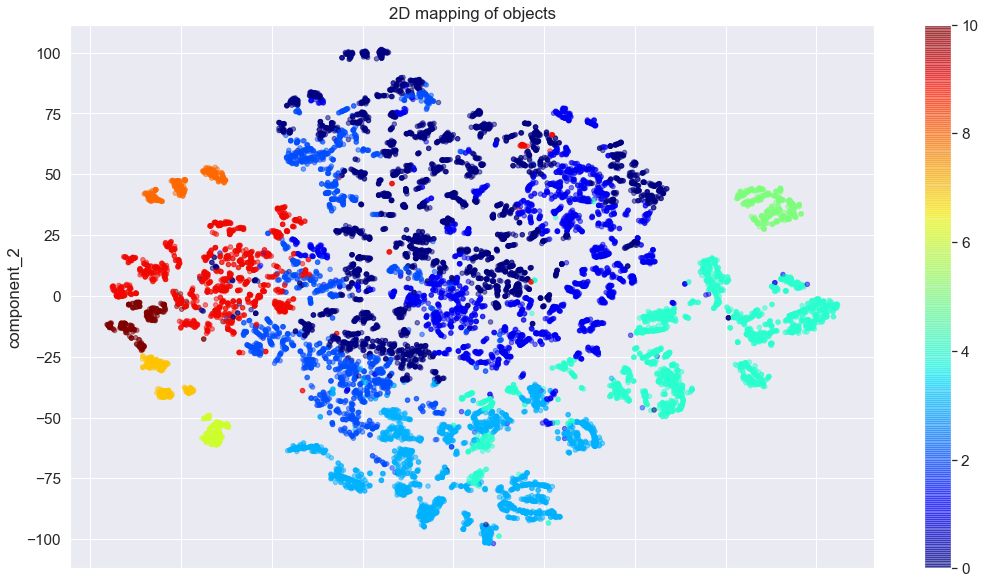

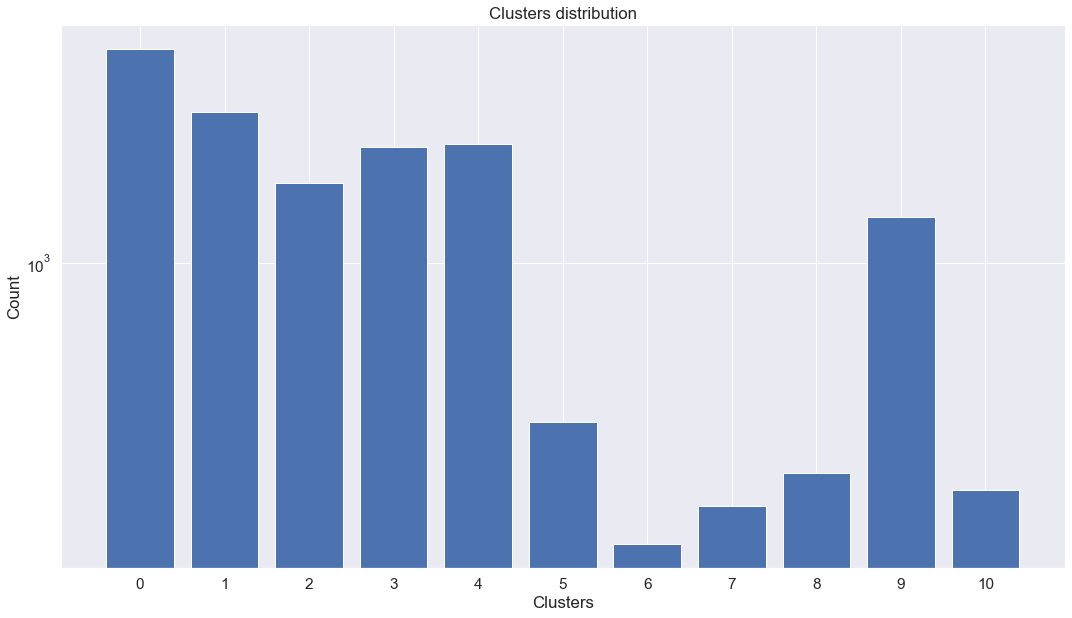

У Агломеративной кластеризации визуально получилось более внятное разбиение на кластеры, её и будем использовать. Забегая вперед скажу, что кластеризация увеличила рейтинг на Каггле на 0.01. Возможно не стоило тратить на неё время, но пусть присутствует в модели.

## Посмотрим на несколько моделей с настройками по умолчанию

In [92]:
model_columns = ['DistrictId',
                 'Rooms',
                 'Square',
                 'LifeSquare',
                 'KitchenSquare',
                 'Floor',
                 'HouseFloor',
                 'HouseYear',
                 'Ecology_1',
                 'Ecology_2',
                 'Ecology_3',
                 'Social_1',
                 'Social_2',
                 'Social_3',
                 'Helthcare_2',
                 'Shops_1',
                 'Shops_2',
                 'Price',
                 'kt_ratio',
                 'rm_ratio',
                 'other_sq',
                 'int_square',
                 'orig_both_sq',
                 'livesq_nonan',
                 'district_size',
                 'med_district_price', 
                 'med_district_psqm',
                 'year_cat', 
                 'med_year_rooms_price',
                 'med_year_rooms_psqm']

cat_features = ['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2', 'roomsq']

for cat_column in cat_features:
    if cat_column in df_all.columns:
        df_all[cat_column] = df_all[cat_column].astype('category')

In [93]:
# обучающий датасет
train_df = df_all[df_all.learn == 1][model_columns]
# тестовый датасет
test_df = df_all[df_all.learn == 0][model_columns]
test_df.drop('Price', axis=1, inplace=True)

X = train_df.drop('Price', axis=1)
y = train_df['Price']

txt = ('Размер ', ' пропусков ')
print(f'{txt[0]}трейна: {X.shape}{txt[1]}{X.isna().sum().sum()}')
print(f'{txt[0]}теста: {test_df.shape}{txt[1]}{test_df.isna().sum().sum()}')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                      shuffle=True,
                                                      random_state=SEED,
                                                      stratify=X.Social_1
                                                      )
print()
print(f'{txt[0]}X_train: {X_train.shape}{txt[1]}{X_train.isna().sum().sum()}')
print(f'{txt[0]}X_valid: {X_valid.shape}{txt[1]}{X_valid.isna().sum().sum()}')

Размер трейна: (10000, 29) пропусков 0
Размер теста: (5000, 29) пропусков 0

Размер X_train: (8000, 29) пропусков 0
Размер X_valid: (2000, 29) пропусков 0


In [94]:
def find_depth(use_model, not_sklearn=False, show_plot=True):
    print(use_model)
    # Подберем оптимальное значение глубины обучения дерева.
    scores = pd.DataFrame(columns=['max_depth', 'train_score', 'valid_score'])
    max_depth_values = range(3, 18)
    for max_depth in max_depth_values:
        print(f'max_depth = {max_depth}')
        if not_sklearn:
            find_model = use_model(random_state=SEED, max_depth=max_depth,
                                   num_leaves=63)
        else:
            find_model = use_model(random_state=SEED, max_depth=max_depth,
                                   criterion='mse')

        find_model.fit(X_train, y_train)

        y_train_pred = find_model.predict(X_train)
        y_valid_pred = find_model.predict(X_valid)
        train_score = r2(y_train, y_train_pred)
        valid_score = r2(y_valid, y_valid_pred)

        print(f'\ttrain_score = {train_score:.7f}')
        print(f'\tvalid_score = {valid_score:.7f}\n')

        scores.loc[len(scores)] = [max_depth, train_score, valid_score]
    scores.max_depth = scores.max_depth.astype(int)
    scores_data = pd.melt(scores,
                          id_vars=['max_depth'],
                          value_vars=['train_score', 'valid_score'],
                          var_name='dataset_type',
                          value_name='score')
    if show_plot:
        # Визуализация
        plt.figure(figsize=(12, 7))
        sns.lineplot(x='max_depth', y='score', hue='dataset_type',
                     data=scores_data)
        plt.show()
    print(scores.sort_values('valid_score', ascending=False))
    print()
    print('Наилучший результат с параметрами:')
    print(scores.loc[scores.valid_score.idxmax()])
    print()

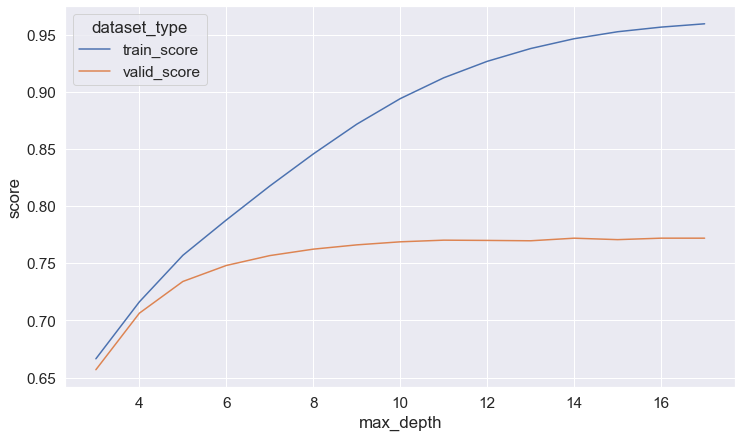

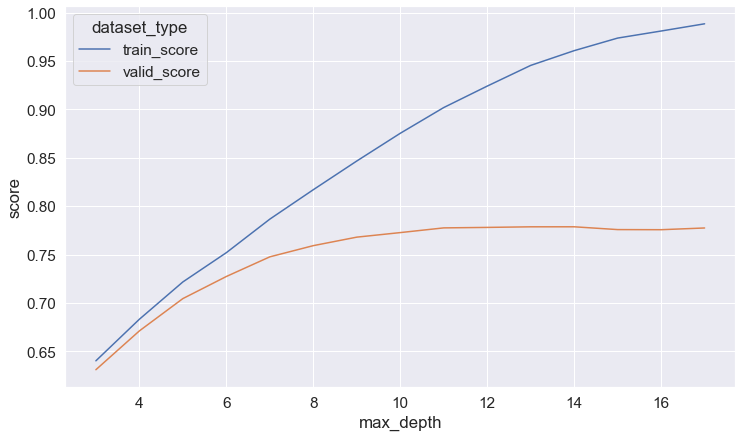

<class 'lightgbm.sklearn.LGBMRegressor'>
max_depth = 3
	train_score = 0.8128960
	valid_score = 0.7771243

max_depth = 4
	train_score = 0.8412331
	valid_score = 0.7845424

max_depth = 5
	train_score = 0.8669081
	valid_score = 0.7819104

max_depth = 6
	train_score = 0.8924744
	valid_score = 0.7827042

max_depth = 7
	train_score = 0.9093176
	valid_score = 0.7798842

max_depth = 8
	train_score = 0.9214135
	valid_score = 0.7810159

max_depth = 9
	train_score = 0.9251242
	valid_score = 0.7760568

max_depth = 10
	train_score = 0.9281431
	valid_score = 0.7793120

max_depth = 11
	train_score = 0.9321449
	valid_score = 0.7810506

max_depth = 12
	train_score = 0.9309727
	valid_score = 0.7817299

max_depth = 13
	train_score = 0.9348039
	valid_score = 0.7788847

max_depth = 14
	train_score = 0.9334082
	valid_score = 0.7784624

max_depth = 15
	train_score = 0.9354246
	valid_score = 0.7796546

max_depth = 16
	train_score = 0.9359567
	valid_score = 0.7770663

max_depth = 17
	train_score = 0.9368063
	v

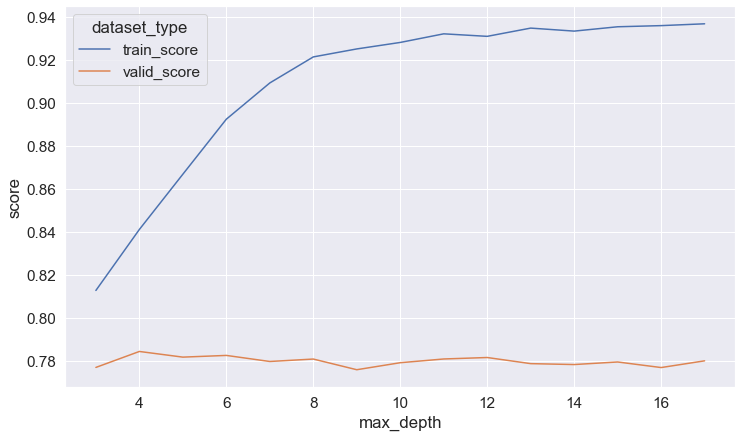

    max_depth  train_score  valid_score
1           4     0.841233     0.784542
3           6     0.892474     0.782704
2           5     0.866908     0.781910
9          12     0.930973     0.781730
8          11     0.932145     0.781051
5           8     0.921413     0.781016
14         17     0.936806     0.780189
4           7     0.909318     0.779884
12         15     0.935425     0.779655
7          10     0.928143     0.779312
10         13     0.934804     0.778885
11         14     0.933408     0.778462
0           3     0.812896     0.777124
13         16     0.935957     0.777066
6           9     0.925124     0.776057

Наилучший результат с параметрами:
max_depth      4.000000
train_score    0.841233
valid_score    0.784542
Name: 1, dtype: float64

Wall time: 4.04 s


In [95]:
%%time
find_depth(LGBMRegressor, True)

### Наилучший результат был достигнут с моделью LGBMRegressor - её будем настраивать.
Были опробованы модели: RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
LGBMRegressor и CatBoostRegressor. Первые три долго считаются, CatBoostRegressor взлетел с трудом с настройками по умолчанию, возможно нужна настройка параметров. LGBMRegressor метрика чуть выше остальных и более высокая скорость работы.

Весь вышенаписанный код оформим в виде классов

In [96]:
def export_to_excel(data: pd.DataFrame) -> None:
    """
    # экспорт датафрема в эксель
    Convert the dataframe to an XlsxWriter Excel object.
    Note that we turn off default header and skip one row to allow us
    to insert a user defined header.
    :param data: dataframe
    :return: None
    """
    name_data = data.name
    file_xls = os.path.join(PATH_EXPORT, f'{name_data}.xlsx')
    writer = pd.ExcelWriter(file_xls, engine='xlsxwriter')
    data.to_excel(writer, sheet_name=name_data, startrow=1,
                  header=False, index=False)
    # Get the xlsxwriter workbook and worksheet objects.
    workbook = writer.book
    worksheet = writer.sheets[name_data]
    # Add a header format.
    font_name = 'Arial'
    header_format = workbook.add_format({
        'font_name': font_name,
        'font_size': 10,
        'bold': True,
        'text_wrap': True,
        'align': 'center',
        'valign': 'center',
        'border': 1})
    # Write the column headers with the defined format.
    worksheet.freeze_panes(1, 0)
    for col_num, value in enumerate(data.columns.values):
        worksheet.write(0, col_num, value, header_format)
    cell_format = workbook.add_format()
    cell_format.set_font_name(font_name)
    cell_format.set_font_size(12)
    for num, value in enumerate(data.columns.values):
        if value == 'time_stamp':
            width = 19
        elif value in ('mdl', 'folds'):
            width = 8
        elif value in ('max_depth', 'r2_train', 'r2_valid'):
            width = 14
        else:
            width = 32
        worksheet.set_column(num, num, width, cell_format)
    worksheet.autofilter(0, 0, len(data) - 1, len(data) - 1)
    writer.save()
    # End excel save


def evaluate_preds(train_true, train_pred, test_true, test_pred):
    """
    Отображение теста и предсказаний
    :param train_true:
    :param train_pred:
    :param test_true:
    :param test_pred:
    :return: None
    """
    print("Train R2:\t" + str(round(r2(train_true, train_pred), 5)))
    print("Valid R2:\t" + str(round(r2(test_true, test_pred), 5)))

    check_train = pd.DataFrame(
        {"true": train_true, "pred": train_pred.flatten()})
    check_test = pd.DataFrame({"true": test_true, "pred": test_pred.flatten()})

    plt.figure(figsize=(15, 12))
    plt.title('Тренировочные предсказания vs Валидационные предсказания')
    sns.scatterplot(data=check_train, x="pred", y="true", alpha=.5,
                    label="Train data")
    sns.scatterplot(data=check_test, x="pred", y="true", alpha=.5,
                    label="Valid data")
    plt.show()


def memory_compression(df_in):
    """
    Изменение типов данных для экономии памяти
    :param df_in: исходный ДФ
    :return: сжатый ДФ
    """
    df = df_in.copy(deep=True)
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        if str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


class ReadWriteDataset:
    """Класс для записи/чтения датасета"""

    @staticmethod
    def read_dataset(name_file=''):
        """
        Чтение датасета
        :param name_file: имя файла
        :return: ДФ c датасетом
        """
        if os.access(name_file, os.F_OK):
            file_pickle = name_file.replace('.csv', '.pkl')
            if os.access(file_pickle, os.F_OK):
                df = pd.read_pickle(file_pickle)
            else:
                df = pd.read_csv(name_file, sep=';', index_col='Id')
                df.Floor = df.Floor.astype(int)
                df.HouseFloor = df.HouseFloor.astype(int)
            return df
        return pd.DataFrame()

    @staticmethod
    def write_dataset(df, name_file='df_all.csv'):
        """
        Сохранение датасета
        :param df: входной ДФ
        :param name_file: имя файла, куда записать
        :return: None
        """
        file_pickle = name_file.replace('.csv', '.pkl')
        df.to_csv(name_file, sep=';')
        df.to_pickle(file_pickle)


class DataPreprocessing(ReadWriteDataset):
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.number_iterations = 2
        self.dfg = pd.DataFrame
        self.msk = pd.DataFrame
        self.df_all = pd.DataFrame
        self.rooms_square_quantile = dict()
        self.medians = None
        self.dfg_HouseYear_min = None
        self.file_houses = 'moscow_houses.csv'
        self.years_floors = ([1957, 14], [1960, 12], [1961, 12], [1977, 22])
        self.new_columns = ['rooms_good', 'square_good', 'livesq_good',
                            'orig_both_sq', 'livesq_nonan', 'kitchen_good',
                            'other_sq_good', 'rm_ratio_good', 'house_fl_good',
                            'house_fl_nonan', 'house_hy_good']

    @staticmethod
    def concat_df(df_train, df_test):
        """Объединение датафреймов"""
        df_train['learn'] = 1
        df_test['learn'] = 0
        df = pd.concat([train, test])
        df.DistrictId = df.DistrictId.astype(int)
        df.Rooms = df.Rooms.astype(int)
        df.HouseFloor = df.HouseFloor.astype(int)
        df.KitchenSquare = df.KitchenSquare.astype(int)
        return df

    def fit(self, df, name_file=''):
        """Сохранение статистик"""
        # Расчет медиан
        self.medians = df.median()
        self.dfg = df.groupby('HouseYear', as_index=False).HouseFloor.max().astype(int)
        self.dfg['DataKind'] = 'Датасет'

        # подготовка данных по домам
        if not name_file:
            name_file = self.file_houses
        # распределение этажности домов по годам с сайта МинЖКХ
        # https://dom.mingkh.ru/moskva/moskva/
        if os.access(name_file, os.F_OK):
            houses = pd.read_csv(name_file, sep=';', index_col='pos')
            houses['area'] = pd.to_numeric(houses['area'], errors='coerce')
            houses['HouseYear'] = pd.to_numeric(houses['HouseYear'],
                                                errors='coerce')
            houses['HouseFloor'] = pd.to_numeric(houses['HouseFloor'],
                                                 errors='coerce')
            houses.dropna(inplace=True)
            houses.HouseYear = houses.HouseYear.astype(int)
            houses.HouseFloor = houses.HouseFloor.astype(int)
            houses.HouseYear = houses.HouseYear - 1
            msk = houses[houses.HouseYear >= self.dfg.HouseYear.min()]
            msk = msk.groupby('HouseYear',
                              as_index=False).HouseFloor.max().astype(int)
        else:
            msk = self.dfg.copy(deep=True)
            for year, floor in self.years_floors:
                msk.loc[msk.HouseYear == year, 'HouseFloor'] = floor
        self.msk = msk.sort_values('HouseYear')
        self.msk['DataKind'] = 'Cайт ЖКХ'

    @property
    def group_year_floor(self):
        """
        Группировка данных для отображения максимальной этажности домов по году
        :return: объединенные: ДФ по строкам, ДФ по столбцам
        """
        df_concat = pd.concat([self.dfg, self.msk], axis=0)
        df_merged = self.dfg[['HouseYear', 'HouseFloor']].merge(
            self.msk[['HouseYear', 'HouseFloor']], on='HouseYear')
        df_merged.columns = ['HouseYear', 'HouseFloor', 'HouseFloor_MSK']
        return df_concat, df_merged

    def fill_square(self, row, name_field, good_field):
        """
        Заполнение Square и KitchenSquare
        :param row: строка датафрейма
        :param name_field: имя поля, которое заполняем
        :param good_field: имя поля для отбора записей, какие корректируем
        :return: площадь
        """
        # если это правильная запись - просто выход и возврат её значения
        if row[good_field]:
            return row[name_field]

        koefic = 0.1
        square = row['Square']
        min_sq = square * (1 - koefic)
        max_sq = square * (1 + koefic)

        conditions = [(self.df_all['DistrictId'] == row['DistrictId']),
                      (self.df_all['HouseYear'] == row['HouseYear']),
                      (self.df_all['Square'] > min_sq),
                      (self.df_all['Square'] < max_sq),
                      True]
        if name_field == 'Square':
            idx_end = 4
            for idx_c in range(idx_end - 1, len(conditions)):
                conditions[idx_c] = True
        else:
            idx_end = len(conditions)
        tmp = pd.DataFrame()
        for idx_c in range(idx_end):
            if idx_c != 2:
                tmp = self.df_all.loc[(self.df_all[good_field] > 0) &
                                      (self.df_all['Rooms'] == row['Rooms']) &
                                      conditions[0] &
                                      conditions[1] &
                                      conditions[2] &
                                      conditions[3]]
                if len(tmp):
                    break
            conditions[idx_c] = True
        if len(tmp):
            if name_field == 'KitchenSquare':
                return int(round(tmp[name_field].median() + 0.1, 0))
            else:
                sq_mean = tmp[name_field].mean()
                if name_field == 'LifeSquare' and sq_mean > square:
                    sq_mean = square
                return sq_mean
        return row[name_field]

    @staticmethod
    def recalc_square(df_in):
        """
        расчет дополнительных фич
        :return: ДФ
        """
        df = df_in.copy(deep=True)
        df['kt_ratio'] = df.Square / df.KitchenSquare
        df['rm_ratio'] = df.LifeSquare / df.Rooms
        df['other_sq'] = df.Square - df.KitchenSquare - df.LifeSquare
        df['int_square'] = df.Square.round(0).astype(int)
        return df

    def transform_rooms(self, df_in):
        """
        Заполнение кол-ва комнат
        :param df_in: входной ДФ
        :return: измененный ДФ
        """
        df = df_in.copy(deep=True)
        # Rooms
        # заполним отсутствующее число комнат по минимальной разнице площади
        # квартиры и медианного значения площади в этом районе
        df.loc[(df.Rooms == 0) | (df.Rooms > 6), 'rooms_good'] = 0
        tmp = df[df.rooms_good == 0]
        list_index = tmp.index
        districts = tmp.DistrictId.unique()
        tmp = df[df.DistrictId.isin(districts) & ~df.index.isin(list_index)]
        grooms = tmp.groupby(['DistrictId', 'Rooms'],
                             as_index=False).agg({'Square': 'median'})
        grooms.columns = ['DistrictId', 'Rooms', 'sq_median']
        for idx in list_index:
            grooms['delta'] = abs(grooms.sq_median - df.loc[idx, 'Square'])
            id_dst = df.loc[idx, 'DistrictId']
            idx_min = grooms[grooms.DistrictId == id_dst].delta.idxmin()
            df.loc[idx, 'Rooms'] = int(grooms.loc[idx_min]['Rooms'])
        # при сопоставлении кол-ва комнат, площади и цены были выявлены выбросы
        tmp = df[df.Rooms == 5]
        # площадь соответствует количеству комнат = 1 с медианной площадью 40.3
        for idx in tmp[tmp.Price < tmp.Price.median() / 2].index:
            df.loc[idx, 'Rooms'] = 1
            df.loc[idx, 'rooms_good'] = 0
        return self.recalc_square(df)

    def transform_rooms_add(self, df_in):
        """
        Изменние кол-ва комнат - тонкая настройка
        :param df_in: входной ДФ
        :return: измененный ДФ
        """
        df = df_in.copy(deep=True)
        # исправление данных по шестикомнатной квартире на двухкомнатную
        room_idx = df.query('Rooms == 6 and Square < 60').index
        df.loc[room_idx, 'Rooms'] = 2
        # исправление данных по шестикомнатной квартире на пятикомнатную
        idxes = df.query('Rooms == 6 and Square < 120').index
        room_idx.append(idxes)
        df.loc[idxes, 'Rooms'] = 5
        df.loc[room_idx, 'KitchenSquare'] = 10
        df.loc[room_idx, 'kitchen_good'] = 0
        # Оставшиеся шестикомнатные квартиры преобразуем в пятикомнатные
        idxes = df.query('Rooms == 6').index
        df.loc[idxes, 'Rooms'] = 5
        room_idx.append(idxes)
        # Двух-трехкомнатные квартиры в общей площадью < 32
        # преобразуем в однокомнатные
        idxes = df.query('Rooms in (2, 3) and Square < 32').index
        df.loc[idxes, 'Rooms'] = 1
        room_idx.append(idxes)
        # Трехкомнатные квартиры в общей площадью < 40
        # преобразуем в двухкомнатные
        idxes = df.query('Rooms == 3 and Square < 40').index
        df.loc[idxes, 'Rooms'] = 2
        room_idx.append(idxes)
        # 4х комнатные, с общей площадью < 50 преобразуем в двухкомнатные
        idxes = df.query('Rooms == 4 and Square < 50').index
        df.loc[idxes, 'Rooms'] = 2
        room_idx.append(idxes)
        # 5ти комнатные, с общей площадью < 60 преобразуем в трехкомнатные
        idxes = df.query('Rooms == 5 and Square < 60').index
        df.loc[idxes, 'Rooms'] = 3
        room_idx.append(idxes)
        df.loc[room_idx, 'rooms_good'] = 0
        return self.recalc_square(df)

    def transform_life_square_square(self, df_in):
        """
        Заполнение общей и жилой площади
        :param df_in: входной ДФ
        :return: измененный ДФ
        """
        df = df_in.copy(deep=True)
        # LifeSquare, Square
        # присвоим значения LifeSquare = Square, если LifeSquare > Square * 2
        # или если LifeSquare > Square * 1.2 и LifeSquare > 120
        term1 = (df.LifeSquare > df.Square * 2)
        term2 = ((df.LifeSquare > df.Square * 2) & (
                df.LifeSquare > 120))
        idxes = df[term1 | term2].index
        df.loc[idxes, 'LifeSquare'] = df.loc[idxes, 'Square'] - 0.1
        df.loc[idxes, 'livesq_good'] = 0
        # очистим LifeSquare если LifeSquare > 280
        df.loc[df.LifeSquare > 280, 'LifeSquare'] = 0
        df.loc[df.LifeSquare > 280, 'livesq_good'] = 0
        # поменяем значения LifeSquare <-> Square, если LifeSquare > Square
        idxes = df[df.LifeSquare > df.Square].index
        df.loc[idxes, ['Square', 'LifeSquare']] = df.loc[
            idxes, ['LifeSquare', 'Square']].values
        df.loc[idxes, 'orig_both_sq'] = 0
        # удаление выбросов Square
        df.loc[(df.Square < 13) | (df.Square > 280), 'square_good'] = 0
        self.df_all = df
        df['new_sq'] = df.apply(
            lambda rowx: self.fill_square(rowx, 'Square', 'square_good'),
            axis=1)
        df['Square'] = df['new_sq']
        df.drop(['new_sq'], axis=1, inplace=True)
        return self.recalc_square(df)

    def fill_nan_life_square(self, df_in):
        """
        Заполнение отсутствущей жилой площади
        :param df_in: входной ДФ
        :return: измененный ДФ
        """
        df = df_in.copy(deep=True)
        # отсутствующую жилую площадь будем заполнять средней площадью квартир
        # из этого района, количества комнат и дома одного года постройки.
        # Если не нашли дома по году, проделаем тоже самое без года
        # удаление пропусков LifeSquare
        df.loc[pd.isna(df.LifeSquare), 'livesq_nonan'] = 0
        self.df_all = df
        df['new_ls1'] = df.apply(lambda rowx: self.fill_square(rowx,
                                                               'LifeSquare',
                                                               'livesq_nonan'),
                                 axis=1)
        # второй этап
        tmp = df[df.livesq_nonan > 0]
        grooms = tmp.groupby(['DistrictId', 'Rooms'],
                             as_index=False).aggregate({'Square': 'mean',
                                                        'LifeSquare': 'mean'})
        grooms.columns = ['DistrictId', 'Rooms', 'sq_mean', 'lq_mean']
        # заполним отсутствующие жилую площадь по минимальной разнице площади
        # квартиры и медианного значения площади в этом районе
        df['new_ls2'] = df.LifeSquare
        for idx in df[df.livesq_nonan < 1].index:
            id_dst = df.loc[idx, 'DistrictId']
            grooms['delta'] = abs(grooms.sq_mean - df.loc[idx, 'Square'])
            idx_tmp = grooms[grooms.DistrictId == id_dst]
            if not len(idx_tmp):
                idx_tmp = grooms
            idx_min = idx_tmp.delta.idxmin()
            df.loc[idx, 'new_ls2'] = grooms.loc[idx_min]['lq_mean']
            min_ls = df.loc[idx, ['new_ls1', 'new_ls2']].min()
            max_ls = df.loc[idx, ['new_ls1', 'new_ls2']].max()
            if max_ls <= df.loc[idx, 'Square'] * 0.8:
                df.loc[idx, 'LifeSquare'] = max_ls
            else:
                df.loc[idx, 'LifeSquare'] = min_ls
        df.drop(['new_ls1', 'new_ls2'], axis=1, inplace=True)
        return self.recalc_square(df)

    def fill_kitchen_square(self, df_in):
        """
        Заполнение площади кухни
        :param df_in: входной ДФ
        :return: измененный ДФ
        """
        df = df_in.copy(deep=True)
        #  выбросами будем считать площадь кухни в квартирах с комнатами:
        #  1к < 3м, 2к < 4м, остальные < 5м.
        #  Так же выбросами будем считать если площадь кухни меньше
        #  оставшейся площади = Square - LifeSquare
        df['kt_ratio'] = df.Square / df.KitchenSquare
        rooms_cond = [(df.Rooms == 1), (df.Rooms == 2), (df.Rooms >= 3)]
        ksq, k_rat = (3, 4, 5), (2.3, 2.4, 3.2)
        # отметка выбросов по площади кухни
        for idx, cnd in enumerate(rooms_cond):
            df.loc[cnd & (df.KitchenSquare < ksq[idx]), 'kitchen_good'] = 0
            df.loc[cnd & (df.kt_ratio < k_rat[idx]), 'kitchen_good'] = 0
        # площадь кухни будем заполнять по медианной площади кухни у квартир
        # из этого района, количества комнат и дома одного года постройки.
        # Если не нашли дома по году, проделаем тоже самое без года
        # удаление выбросов KitchenSquare
        self.df_all = df
        df['new_ks'] = df.apply(lambda rowx: self.fill_square(rowx,
                                                              'KitchenSquare',
                                                              'kitchen_good'),
                                axis=1)
        df['KitchenSquare'] = df['new_ks']
        df.drop(['new_ks'], axis=1, inplace=True)
        df = self.recalc_square(df)
        # исправление косяков с площадями: пересчитаем площадь кухни
        cond_other = (df.Square < 26) & (df.other_sq < 0)
        df.loc[cond_other, 'KitchenSquare'] = df.loc[cond_other, 'Square'] - \
                                              df.loc[cond_other, 'LifeSquare']
        # если площадь кухни стала = 0 - поставим медианное значение
        ks_null = (df.Square < 26) & (df.KitchenSquare < 1)
        med_ks = df[(df.Square < 26) &
                    (df.KitchenSquare > 0)].KitchenSquare.median()
        df.loc[ks_null, 'KitchenSquare'] = med_ks
        df.loc[ks_null, 'LifeSquare'] = df.loc[ks_null, 'LifeSquare'] - med_ks
        df.KitchenSquare = df.KitchenSquare.astype(int)
        df = self.recalc_square(df)

        # для проставления адекватной площади кухни сгруппируем данные
        # по кол-ву комнат и целой площади
        cond_grp = (df.other_sq > 0) | (df.kitchen_good > 0)
        inv_cond = ((df.other_sq <= 0) & (df.kitchen_good < 1))
        group_rooms = self.make_grp_df(df, cond_grp, inv_cond)
        # установка KitchenSquare
        # для (Square > 26) & (other_sq <= 0) & (kitchen_good < 1)
        cond_ks = (df.Square > 26) & inv_cond
        for idx in df[cond_ks].index:
            intsq = df.loc[idx, 'rooms_intsq']
            df.loc[idx, 'KitchenSquare'] = group_rooms.loc[intsq, 'ks_median']
        return self.recalc_square(df)

    def transform_life_square(self, df_in):
        """
        Заполняем LifeSquare, где средняя площадь меньше порога в 9.8 кв.м
        :return: ДФ
        """
        df = df_in.copy(deep=True)
        # отметка, что средняя площадь комнаты менее допустимого порога
        df.loc[(df.Square > 26) & (df.rm_ratio < 9.8), 'rm_ratio_good'] = 0
        # Заполняем LifeSquare
        cond_grp = ((df.other_sq > 0) & (df.rm_ratio > 9.8))
        inv_cond = ((df.other_sq <= 0) | (df.rm_ratio < 9.8))
        group_rooms = self.make_grp_df(df, cond_grp, inv_cond)
        cond_ks = (df.Square > 26) & inv_cond
        for idx in df[cond_ks].index:
            intsq = df.loc[idx, 'rooms_intsq']
            df.loc[idx, 'LifeSquare'] = group_rooms.loc[intsq, 'lq_median']
        df = self.recalc_square(df)
        # посчитаем LifeSquare = Square - KitchenSquare - other_sq
        for k, cond_sq in enumerate(
                [((df.Square > 58) & (df.Square < 75)),
                 ((df.Square > 110) & (df.Square < 130))]):
            for idx in df[(df.other_sq <= 0) & cond_sq].index:
                sq = df.loc[idx, 'Square']
                ks = df.loc[idx, 'KitchenSquare']
                mos = df[cond_sq]['other_sq'].mean()
                rms = df.loc[idx, 'Rooms']
                df.loc[idx, 'LifeSquare'] = sq - ks - mos / (rms - k)
        return self.recalc_square(df)

    def transform_floors(self, df_in):
        """
        Заполняем выбросы по этажам, отсутствующие и перепутанные этажи
        :return: ДФ
        """
        df = df_in.copy(deep=True)

        # В этой квартире ошиблись номером этажа, вместо 18, написали 78
        df.loc[df.Floor == 78, 'Floor'] = 18
        # исправленяем этажи в домах более 48 этажей
        grp_field = 'HouseFloor'
        inv_cond = (df[grp_field] > 48) & (df.HouseYear == 1977)
        idx_cond = df[inv_cond].index
        id_rooms = df.loc[idx_cond, 'Rooms'].unique()
        cond_grp = (df[grp_field] > 0) & (df[grp_field] <= 48) & \
                   (df.HouseYear == 1977) & df.Rooms.isin(id_rooms) & \
                   ~df.index.isin(idx_cond)
        group_rooms = self.make_grp_df(df, cond_grp, inv_cond)
        for idx in idx_cond:
            intsq = df.loc[idx, 'rooms_intsq']
            df.loc[idx, grp_field] = group_rooms.loc[intsq, 'hf_median']
            df.loc[idx, 'house_fl_good'] = 0

        # пометим нулевую этажность домов
        df.loc[df.HouseFloor < 1, 'house_fl_nonan'] = 0
        # Для записей HouseFloor == 0
        # заполним этажность медианным значением у аналогичных квартир
        grp_field = 'HouseFloor'
        inv_cond = (df[grp_field] < 1)
        idx_cond = df[inv_cond].index
        cond_grp = (df[grp_field] > 0) & ~df.index.isin(idx_cond)
        group_rooms = self.make_grp_df(df, cond_grp, inv_cond)
        for idx in idx_cond:
            intsq = df.loc[idx, 'rooms_intsq']
            df.loc[idx, grp_field] = group_rooms.loc[intsq, 'hf_median']
            # если вдруг найденная этажность дома меньше нужной запишем часто
            # используемое значение в этом районе
            if df.loc[idx, grp_field] < df.loc[idx, 'Floor']:
                district = df.loc[idx, 'DistrictId']
                square = df.loc[idx, 'Square'] * 0.6
                hfloor = df.loc[idx, grp_field]
                hf_median = df.loc[(df.Square > square) &
                                   (df.HouseFloor >= hfloor) &
                                   (df.DistrictId == district),
                                   'HouseFloor'].value_counts().index[0]
                df.loc[idx, grp_field] = hf_median
        # поменяем значения HouseFloor <-> Floor, если HouseFloor < Floor
        idxes = df[df.HouseFloor < df.Floor].index
        df.loc[idxes, ['Floor', 'HouseFloor']] = df.loc[
            idxes, ['HouseFloor', 'Floor']].values
        # пометим кривую этажность домов
        df.loc[idxes, 'house_fl_good'] = 0

        # Группировка данных c максимальной этажностью домов по годам
        tmp_concat, tmp_merged = self.group_year_floor
        # отбор домов за период (1920, 2000) где разница больше трех этажей
        tmp_merged = tmp_merged.query('HouseFloor - HouseFloor_MSK > 3 and '
                                      'HouseYear > 1920 and HouseYear < 2000')
        years_floors = tmp_merged[['HouseYear',
                                   'HouseFloor_MSK']].to_dict('split')['data']
        # исправляем год дома, если этажность больше построенных домов
        grp_field = 'HouseYear'
        for year, floors in years_floors:
            inv_cond = (df[grp_field] == year) & (df.HouseFloor - floors > 1)
            set_floors = sorted(df[inv_cond].HouseFloor.unique())
            for floor in set_floors:
                flr_cond = (df.HouseFloor == floor)
                inv_cond = (df[grp_field] == year) & flr_cond
                idx_cond = df[inv_cond].index
                cond_grp = (df[grp_field] != year) & flr_cond & \
                           ~df.index.isin(idx_cond)
                cond = (df[grp_field] != year) & ~df.index.isin(
                    idx_cond)
                group_rooms = self.make_grp_df(df, cond_grp, inv_cond, cond,
                                               floor)
                for idx in idx_cond:
                    intsq = df.loc[idx, 'rooms_intsq']
                    df.loc[idx, grp_field] = group_rooms.loc[intsq, 'hy_mode']
                    df.loc[idx, 'house_hy_good'] = 0
        return self.recalc_square(df)

    def transform(self, df_in):
        """
        Трансформация данных
        :return: ДФ
        """
        # если есть файл с заполненными HouseYear после первой итерации
        # - достаточно одной итерации
        if os.access(FILE_YEARS, os.F_OK):
            self.number_iterations = 1

        for n_iter in range(self.number_iterations):
            if self.number_iterations == 2:
                print(f"{['Первый', 'Второй'][n_iter]} этап обработки данных")

            df = df_in.copy(deep=True)
                        
            # исправим 2 ошибочных года
            df.loc[df.HouseYear == 4968, 'HouseYear'] = 1968
            df.loc[df.HouseYear == 20052011, 'HouseYear'] = 2011
            current_year = datetime.now().year
            df.loc[df.HouseYear > current_year, 'HouseYear'] = current_year

            # есть файл с заполненными HouseYear после первой итерации - читаем
            # т.к. на основании года будут заполняться отсутствующие площади
            if os.access(FILE_YEARS, os.F_OK):
                changed_years = pd.read_csv(FILE_YEARS, sep=';',
                                            index_col='Id')
                idx_years = changed_years.index
                columns_years = ['Floor', 'HouseFloor', 'HouseYear',
                                 'house_fl_good', 'house_fl_nonan',
                                 'house_hy_good']
                df.loc[idx_years, columns_years] = changed_years

            self.df_all = df

            # удалим Healthcare_1
            if 'Healthcare_1' in df.columns:
                df.drop('Healthcare_1', axis=1, inplace=True)

            # пропишем, что изначально эти признаки в датасете хорошие
            for column in self.new_columns:
                df[column] = 1
            df = self.recalc_square(df)
            df.loc[df.other_sq <= 0, 'other_sq_good'] = 0

            # Rooms
            # заполним отсутствующее число комнат по мин.разнице площади
            # квартиры и медианного значения площади в этом районе
            df = self.transform_rooms(df)

            # LifeSquare, Square
            # значения LifeSquare = Square, если LifeSquare > Square * 2
            # или если LifeSquare > Square * 1.2 и LifeSquare > 120
            # поменяем значения LifeSquare <-> Square, если LifeSquare > Square
            # удаление выбросов Square
            df = self.transform_life_square_square(df)

            # Rooms
            # доп. преобразование после этапа transform_life_square_square
            df = self.transform_rooms_add(df)

            # добавление составного поля из двух колонок для индекса
            df['rooms_intsq'] = df.Rooms.astype(str) + '_' + \
                                df.int_square.astype(str)
            df['rooms_intsq'] = df['rooms_intsq'].astype('category')

            # Nan LifeSquare
            # Nan жилую площадь будем заполнять средней площадью квартир
            # из этого района, количества комнат и дома одного года постройки.
            # Если не нашли дома по году, проделаем тоже самое без года
            # удаление пропусков LifeSquare
            df = self.fill_nan_life_square(df)

            # KitchenSquare
            # заполнение отсутствующей площади кухни
            # и исправление ошибок в данных
            df = self.fill_kitchen_square(df)

            # LifeSquare
            # Заполняем LifeSquare, где средняя площадь меньше порога 9.8 кв.м
            df = self.transform_life_square(df)

            # Floor, HouseFloor
            # Заполняем выбросы по этажам, отсутствующие и перепутанные этажи
            df = self.transform_floors(df)

            # если нет файла с заполненными HouseYear после первой итерации -
            # создаем его
            if not os.access(FILE_YEARS, os.F_OK):
                # сохранение измененных годов,
                # чтобы прочитать на следующей итерации
                columns_years = ['Floor', 'HouseFloor', 'HouseYear',
                                 'house_fl_good', 'house_fl_nonan',
                                 'house_hy_good']
                changed_years = df[(df['house_hy_good'] < 1)][columns_years]
                changed_years.to_csv(FILE_YEARS, sep=';')
        # end iterations
        
        df.fillna(self.medians, inplace=True)
        df.loc[df.learn == 0, 'Price'] = np.NaN

        # добавим колонку с ценой 1кв.метра
        df['price_sqm'] = df.Price / df.Square

        # подготовка словаря: кол-во комнат, площадь по квантилям
        for room in range(1, df.Rooms.max() + 1):
            quarters = []
            # # делим на 4 части диапазон площадей
            # for q in np.linspace(0, 1, 5):
            # на 3 части по принципу 80/20%
            for q in (0, .2, .8, 1.):
                quarters.append(df[df.Rooms == room]['int_square'].quantile(q))
            quarters[0] -= 1
            quarters.insert(0, 0)
            self.rooms_square_quantile[room] = [int(q) for q in quarters]

        # заполнение в какой четверти находится площадь квартиры
        df['quart_sq'] = df.apply(lambda row: self.quarters(row), axis=1)
        df['roomsq'] = df['Rooms'] * 10 + df['quart_sq']

        # поделим квартиры на категории в зависимости от года постройки дома
        # по эпохам строительства
        # https://strelkamag.com/ru/article/moscow-housing-map
        years_bins = [0, 1917, 1924, 1953, 1964, 1982, 1991, 2010,
                      df['HouseYear'].max()]
        # заполнение категории года дома
        df['year_cat'] = pd.cut(df.HouseYear, bins=years_bins, labels=False)

        return df

    def quarters(self, rowx):
        bins = self.rooms_square_quantile[rowx.Rooms]
        return pd.cut([rowx.int_square], bins=bins, labels=False)[0]

    @staticmethod
    def make_grp_df(df, cond_grp, inv_cond, add_cond=True, chk_floor=None,
                    test_index=None):
        """
        для проставления адекватной площади кухни сгруппируем данные
        по кол-ву комнат и целой площади
        :param df:  входной ДФ
        :param cond_grp: условие для группировки
        :param inv_cond: условие для "плохих записей", которые нужно править
        :param add_cond: добавочное условие для группировки
        :param chk_floor: условие для проверки этажности
        :param test_index: индекс для тестирования метода
        :return: ДФ с группированными данными
        """

        def calc_min_max(square, koefic=None, check_floor=None):
            if not koefic:
                if square <= 50:
                    koefic = 0.1
                elif square < 150:
                    koefic = 0.05
                else:
                    koefic = 0.2
            min_sq = square * (1 - koefic)
            max_sq = square * (1 + koefic)

            if check_floor:
                add_floor = (df.HouseFloor == check_floor)
            else:
                add_floor = True

            return df[(df['Rooms'] == rooms) &
                      (df['Square'] > min_sq) &
                      (df['Square'] < max_sq) & add_cond & add_floor]

        grpr = df[cond_grp].groupby(['Rooms', 'int_square'],
                                    as_index=False).agg(
            {'LifeSquare': 'median',
             'KitchenSquare': 'median',
             'HouseFloor': 'median',
             'HouseYear': lambda x: x.value_counts().index[0]})
        grpr.columns = ['Rooms', 'int_square', 'lq_median', 'ks_median',
                        'hf_median', 'hy_mode']
        grpr['rooms_intsq'] = grpr.Rooms.astype(
            str) + '_' + grpr.int_square.astype(str)
        grpr['rooms_intsq'] = grpr['rooms_intsq'].astype('category')

        # проверим все ли квартиры найдутся в группировке
        if test_index:
            no_found = df[df.index == test_index]
        else:
            no_found = df[inv_cond & ~df.rooms_intsq.isin(
                grpr.rooms_intsq)].sort_values(['Rooms', 'Square'])
        # Добавим в группировку строки из этой таблицы для отсутствующих
        # значений int_square с группировкой по диапазону Square +/- 10%.
        for idx in no_found.index:
            rooms = no_found.loc[idx, 'Rooms']
            rsquare = no_found.loc[idx, 'Square']
            int_square = no_found.loc[idx, 'int_square']
            for koef in (None, 0.2, 0.25, 0.3):
                tmp = calc_min_max(rsquare, koef, chk_floor)
                if len(tmp):
                    break
            if not len(tmp):
                for koef in (None, 0.2, 0.25, 0.3):
                    tmp = calc_min_max(rsquare, koef, chk_floor - 1)
                    if len(tmp):
                        break
            # Rooms	int_sq sq_median ks_median hf_median hhy_mode rooms_intsq
            idx_rooms_intsq = f'{rooms}_{int_square}'
            if idx_rooms_intsq not in grpr.rooms_intsq.values:
                # print(f'{idx_rooms_intsq} '
                #       f'{tmp.HouseYear.value_counts().index}')
                grpr.loc[len(grpr)] = [rooms, int_square,
                                       tmp.LifeSquare.median(),
                                       tmp.KitchenSquare.median(),
                                       tmp.HouseFloor.median(),
                                       tmp.HouseYear.value_counts().index[0],
                                       idx_rooms_intsq]
        grpr.ks_median = (grpr.ks_median + 0.1).round(0).astype(int)
        grpr.hf_median = (grpr.hf_median + 0.1).round(0).astype(int)
        grpr.hy_mode = (grpr.hy_mode + 0.1).round(0).astype(int)
        # установка нового индекса
        grpr = grpr.set_index('rooms_intsq')
        return grpr


class FeatureGenerator(ReadWriteDataset):
    """Генерация новых фич"""

    def __init__(self):
        """ Инициализация класса """
        self.binary_to_numbers = None
        self.district_size = None
        self.cat_features = ['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2',
                             'rooms_intsq', 'roomsq']
        self.columns_to_group = ['year_cat', 'DistrictId',
                                 'Social_1', 'Social_2', 'Social_3', 'Shops_1']
        self.tsne_columns = []
        self.med_rooms_price_quart = None
        self.med_year_floor_Rooms_price = None
        self.med_year_floor_roomsq_price = None
        self.med_district_rooms_price = None
        self.med_district_year_Rooms_price = None
        self.med_district_year_roomsq_price = None
        self.med_social_rooms_price = None
        self.med_social_year_Rooms_price = None
        self.med_social_year_roomsq_price = None
        self.exclude_columns = ['Id', 'learn', 'price_sqm']
        self.learn_columns = []
        self.dummy = []
        self.dif = 1.6

    def fit(self, df_in):
        """
        Подготовка для добавления новых признаков
        :param df_in: входной ДФ
        :return: None
        """
        df = df_in.copy(deep=True)

        # колонки для кластеризации
        self.tsne_columns = [col for col in df.columns if
                             col not in self.exclude_columns + ['Price']]

        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}

        # DistrictID
        self.district_size = df[
            'DistrictId'].value_counts().reset_index().rename(
            columns={'index': 'DistrictId', 'DistrictId': 'district_size'})

        # группировка по кол-ву комнат с медианной ценой квартиры и кв. метра
        self.med_rooms_price_quart = df[df.learn == 1].groupby(['roomsq']).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_rooms_price',
                     'price_sqm': 'med_rooms_psqm'})
        # print(self.med_rooms_price_quart)

        for name_col in self.columns_to_group:
            name_atr = f'med_{name_col}_price'
            name_sqm = f'med_{name_col}_psqm'
            grp = df[df.learn == 1].groupby(
                [name_col, 'Rooms'], as_index=False).agg(
                {'Price': 'median', 'price_sqm': 'median'}).rename(
                columns={'Price': name_atr, 'price_sqm': name_sqm})
            grp['feat_rooms'] = grp[name_col] * 10 + grp.Rooms
            grp = grp.set_index('feat_rooms')
            setattr(FeatureGenerator, name_atr, grp)
            # более детальная группировка
            name_atr = f'med_{name_col}_rooms_price'
            name_sqm = f'med_{name_col}_rooms_psqm'
            grp = df[df.learn == 1].groupby(
                [name_col, 'Rooms', 'quart_sq'], as_index=False).agg(
                {'Price': 'median', 'price_sqm': 'median'}).rename(
                columns={'Price': name_atr, 'price_sqm': name_sqm})
            setattr(FeatureGenerator, name_atr, grp)

        # группировка по району и кол-ву комнат с медианной ценой квартиры
        # и медионной ценой квадратного метра
        self.med_district_rooms_price = df[df.learn == 1].groupby(
            ['DistrictId', 'Rooms'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_district_rooms_price',
                     'price_sqm': 'med_district_rooms_psqm'})
        self.med_district_rooms_price[
            'dist_rooms'] = self.med_district_rooms_price.DistrictId * 10 + \
                            self.med_district_rooms_price.Rooms
        self.med_district_rooms_price = \
            self.med_district_rooms_price.set_index('dist_rooms')

        # группировка по району, категории года и комнатам с медианной ценой
        # и медионной ценой квадратного метра
        self.med_district_year_Rooms_price = df[df.learn == 1].groupby(
            ['DistrictId', 'year_cat', 'Rooms'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_district_year_rooms_price',
                     'price_sqm': 'med_district_year_rooms_psqm'})

        # группировка по району, категории года и комнатам поделенным на
        # категории с медианной ценой и медионной ценой квадратного метра
        # и медионной ценой квадратного метра
        self.med_district_year_roomsq_price = df[df.learn == 1].groupby(
            ['DistrictId', 'year_cat', 'roomsq'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_district_year_rooms_price',
                     'price_sqm': 'med_district_year_rooms_psqm'})

        # группировка по категории года, этажу и комнатам с медианной ценой
        # и медионной ценой квадратного метра
        self.med_year_floor_Rooms_price = df[df.learn == 1].groupby(
            ['year_cat', 'Floor', 'Rooms'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_year_floor_rooms_price',
                     'price_sqm': 'med_year_floor_rooms_psqm'})

        # группировка по категории года, этажу и комнатам поделенным на
        # категории, с медианной ценой и медионной ценой квадратного метра
        self.med_year_floor_roomsq_price = df[df.learn == 1].groupby(
            ['year_cat', 'Floor', 'roomsq'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_year_floor_rooms_price',
                     'price_sqm': 'med_year_floor_rooms_psqm'})

        # группировка по Social_1 и кол-ву комнат с медианной ценой квартиры
        # и медионной ценой квадратного метра
        self.med_social_rooms_price = df[df.learn == 1].groupby(
            ['Social_1', 'Rooms'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_social_rooms_price',
                     'price_sqm': 'med_social_rooms_psqm'})
        self.med_social_rooms_price[
            'soc_rooms'] = self.med_social_rooms_price.Social_1 * 10 + \
                           self.med_social_rooms_price.Rooms
        self.med_social_rooms_price = \
            self.med_social_rooms_price.set_index('soc_rooms')

        # группировка по Social_1, категории года и комнатам с медианной ценой
        # и медионной ценой квадратного метра
        self.med_social_year_Rooms_price = df[df.learn == 1].groupby(
            ['Social_1', 'year_cat', 'Rooms'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_social_year_rooms_price',
                     'price_sqm': 'med_social_year_rooms_psqm'})

        # группировка по по району, категории года и комнатам поделенным на
        # категории с медианной ценой и медионной ценой квадратного метра
        # и медионной ценой квадратного метра
        self.med_social_year_roomsq_price = df[df.learn == 1].groupby(
            ['Social_1', 'year_cat', 'roomsq'], as_index=False).agg(
            {'Price': 'median', 'price_sqm': 'median'}).rename(
            columns={'Price': 'med_social_year_rooms_price',
                     'price_sqm': 'med_social_year_rooms_psqm'})

    def find_min(self, rowx):
        """
        Исправление разницы между med_year_floor_rooms_price и
        med_district_year_rooms_price больше, чем в полтора раза
        :param rowx: строка ДФ
        :return: более подходящее значение med_year_floor_rooms_price
        """
        fields = ['med_year_cat_rooms_price',
                  'med_DistrictId_rooms_price',
                  'med_Social_1_rooms_price',
                  'med_Social_2_rooms_price',
                  'med_Social_3_rooms_price',
                  'med_Shops_1_rooms_price']
        yfr = rowx.med_year_floor_rooms_price
        dyr = rowx.med_district_year_rooms_price
        dvd = yfr / dyr

        if 1 / self.dif <= dvd <= self.dif:
            return yfr

        values = [rowx[col] for col in fields if abs(rowx[col] - dyr) > 1 and
                  (1 / self.dif <= rowx[col] / dyr <= self.dif)]
        if dvd < 1:
            values_less = [rowx[col] for col in fields if
                           abs(rowx[col] - dyr) > 1 and rowx[col] < dyr and
                           (rowx[col] / dyr > 1 / self.dif or rowx[col] > yfr)]
            if values_less:
                return max(values_less)
            return yfr if not values else max(values)
        else:
            values_over = [rowx[col] for col in fields if
                           abs(rowx[col] - dyr) > 1 and rowx[col] > dyr and
                           (rowx[col] / dyr <= self.dif or rowx[col] < yfr)]
            if values_over:
                return min(values_over)
        return yfr if not values else max(values)

    def make_clusters(self, df, n_clusters):
        """
        Разбиение датасета на кластеры
        :param df:
        :param n_clusters:
        :param all_data: кластеризация на всем датасете
        :return: ДФ с кластерами
        """
        print(f'Кластеризация')
        cls_time = time.time()
        # # исходные колонки
        col_clusters = self.tsne_columns[:17]
        # # колонки после препроцессинга
        # col_clusters = self.tsne_columns

        scaler = RobustScaler()
        train_scaled = pd.DataFrame(scaler.fit_transform(df[col_clusters]),
                                    columns=col_clusters, index=df.index)

        aggl = AgglomerativeClustering(n_clusters=n_clusters)
        labels = aggl.fit_predict(train_scaled)
        labels = pd.DataFrame(data=labels, columns=['cluster'], index=df.index)

        self.dummy.extend(['cluster'])
        print_time(cls_time)
        return labels

    def transform(self, df_in, clusters=0, dummy_cols=[], exclude_cols=[]):
        """
        Преобразование данных
        :param df_in: входной ДФ
        :param clusters: делить данные на количество кластеров
        :param dummy_cols: категорийные колонки для преобразования в признаки
        :param exclude_cols: колонки не участвующие в обработке
        :return: ДС с новыми признаками
        """
        self.dummy = dummy_cols
        df = df_in.copy(deep=True)
        df['Id'] = df.index

        # кодировка категорийных признаков
        df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)
        df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)

        # заполнение размера района
        df = df.merge(self.district_size, on='DistrictId', how='left')
        df['district_size'].fillna(1, inplace=True)

        # заполнение медианной цены квартиры по атрибутам
        for name_col in self.columns_to_group:
            name_atr = f'med_{name_col}_rooms_price'
            name_sqm = f'med_{name_col}_rooms_psqm'
            df = df.merge(getattr(FeatureGenerator, name_atr),
                          on=[name_col, 'Rooms', 'quart_sq'], how='left')
            # отсутствующиие значения заполним из верхнеуровневой группировки
            for idx in df[pd.isna(df[name_atr])].index:
                grp_atr = f'med_{name_col}_price'
                grp_sqm = f'med_{name_col}_psqm'
                grp = getattr(FeatureGenerator, grp_atr)
                dsr = df.loc[idx, name_col] * 10 + df.loc[idx, 'Rooms']
                if dsr in grp.index:
                    prs = grp.loc[dsr, grp_atr]
                    sqm = grp.loc[dsr, grp_sqm]
                else:
                    # отсутствующиие значения заполним из группировки:
                    # район/кол.комнат, если такие значения не найдены -
                    # заполним из группировки: кол-во комнат
                    dsr = df.loc[idx, 'DistrictId'] * 10 + df.loc[idx, 'Rooms']
                    if dsr in self.med_district_rooms_price.index:
                        prs = self.med_district_rooms_price.loc[
                            dsr, 'med_district_rooms_price']
                        sqm = self.med_district_rooms_price.loc[
                            dsr, 'med_district_rooms_psqm']
                    else:
                        roomsq = df.loc[idx, 'roomsq']
                        prs = self.med_rooms_price_quart.loc[
                            roomsq, 'med_rooms_price']
                        sqm = self.med_rooms_price_quart.loc[
                            roomsq, 'med_rooms_psqm']
                df.loc[idx, name_atr] = prs
                df.loc[idx, name_sqm] = sqm

        # заполнение медианной цены по категории года, этажу, кол-ву комнат
        if self.med_year_floor_roomsq_price is not None:
            df = df.merge(self.med_year_floor_roomsq_price,
                          on=['year_cat', 'Floor', 'roomsq'], how='left')
            # заполнение пропущенных значений с уровня группировки  -->
            # заполнение медианной цены по категории года, этажу, кол-ву комнат
            idx_nan = df[pd.isna(df.med_year_floor_rooms_price)].index
            rooms = df.loc[idx_nan].drop(['med_year_floor_rooms_price',
                                          'med_year_floor_rooms_psqm'], axis=1)
            rooms['idx'] = rooms.index
            rooms = rooms.merge(self.med_year_floor_Rooms_price,
                                on=['year_cat', 'Floor', 'Rooms'], how='left')
            rooms = rooms.set_index('idx')
            df.loc[idx_nan, 'med_year_floor_rooms_price'] = rooms.loc[
                idx_nan, 'med_year_floor_rooms_price']
            df.loc[idx_nan, 'med_year_floor_rooms_psqm'] = rooms.loc[
                idx_nan, 'med_year_floor_rooms_psqm']
            # заполнение пропущенных значений с уровня группировки  -->
            # заполнение медианной цены по категории года, кол-ву комнат
            idx_nan = df[pd.isna(df.med_year_floor_rooms_price)].index
            # отметка что для поля "med_year_floor_rooms_price" не нашли данных
            # в группировке
            df['myfrp_good'] = 1
            df.loc[idx_nan, 'myfrp_good'] = 0
            df.loc[idx_nan, 'med_year_floor_rooms_price'] = df.loc[
                idx_nan, 'med_year_cat_rooms_price']
            df.loc[idx_nan, 'med_year_floor_rooms_psqm'] = df.loc[
                idx_nan, 'med_year_cat_rooms_psqm']

        # заполнение медианной цены по району и категории года
        if self.med_district_year_roomsq_price is not None:
            df = df.merge(self.med_district_year_roomsq_price,
                          on=['DistrictId', 'year_cat', 'roomsq'], how='left')
            # заполнение пропущенных значений с уровня группировки -->
            # заполнение медианной цены квартиры по району, году, комнатам
            idx_nan = df[pd.isna(df.med_district_year_rooms_price)].index
            rooms = df.loc[idx_nan].drop(['med_district_year_rooms_price',
                                          'med_district_year_rooms_psqm'],
                                         axis=1)
            rooms['idx'] = rooms.index
            rooms = rooms.merge(self.med_district_year_Rooms_price,
                                on=['DistrictId', 'year_cat', 'Rooms'],
                                how='left')
            rooms = rooms.set_index('idx')
            df.loc[idx_nan, 'med_district_year_rooms_price'] = rooms.loc[
                idx_nan, 'med_district_year_rooms_price']
            df.loc[idx_nan, 'med_district_year_rooms_psqm'] = rooms.loc[
                idx_nan, 'med_district_year_rooms_psqm']
            # заполнение пропущенных значений с уровня группировки -->
            # заполнение медианной цены квартиры по району/году, среднее из них
            idx_nan = df[pd.isna(df.med_district_year_rooms_price)].index
            # отметка что для поля "med_district_year_rooms_price" не нашли
            # данных в группировке
            df['mdyrp_good'] = 1
            df.loc[idx_nan, 'mdyrp_good'] = 0
            prs = (df.loc[idx_nan, 'med_DistrictId_rooms_price'] +
                   df.loc[idx_nan, 'med_year_cat_rooms_price']) / 2
            sqm = (df.loc[idx_nan, 'med_DistrictId_rooms_psqm'] +
                   df.loc[idx_nan, 'med_year_cat_rooms_psqm']) / 2
            df.loc[idx_nan, 'med_district_year_rooms_price'] = prs
            df.loc[idx_nan, 'med_district_year_rooms_psqm'] = sqm

            df['new_yfr'] = df.apply(self.find_min, axis=1)
            df['div_yfrdyr'] = df.med_year_floor_rooms_price / \
                               df.med_district_year_rooms_price
            df['new_div'] = df.new_yfr / df.med_district_year_rooms_price
            cnd = (df.div_yfrdyr < 1 / self.dif) | (df.div_yfrdyr > self.dif)
            df.loc[cnd, 'med_year_floor_rooms_price'] = df.loc[cnd, 'new_yfr']
            df.drop(['new_yfr', 'div_yfrdyr', 'new_div'], axis=1, inplace=True)

        # заполнение медианной цены по Social_1 и категории года
        if self.med_social_year_roomsq_price is not None:
            df = df.merge(self.med_social_year_roomsq_price,
                          on=['Social_1', 'year_cat', 'roomsq'], how='left')
            # заполнение пропущенных значений с уровня группировки -->
            # заполнение медианной цены квартиры по Social_1, году, комнатам
            idx_nan = df[pd.isna(df.med_social_year_rooms_price)].index
            rooms = df.loc[idx_nan].drop(['med_social_year_rooms_price',
                                          'med_social_year_rooms_psqm'],
                                         axis=1)
            rooms['idx'] = rooms.index
            rooms = rooms.merge(self.med_social_year_Rooms_price,
                                on=['Social_1', 'year_cat', 'Rooms'],
                                how='left')
            rooms = rooms.set_index('idx')
            df.loc[idx_nan, 'med_social_year_rooms_price'] = rooms.loc[
                idx_nan, 'med_social_year_rooms_price']
            df.loc[idx_nan, 'med_social_year_rooms_psqm'] = rooms.loc[
                idx_nan, 'med_social_year_rooms_psqm']
            # заполнение пропущенных значений с уровня группировки -->
            # заполнение медианной цены квартиры по району/году, среднее из них
            idx_nan = df[pd.isna(df.med_social_year_rooms_price)].index
            # отметка что для поля "med_social_year_rooms_price" не нашли
            # данных в группировке
            df['msyrp_good'] = 1
            df.loc[idx_nan, 'msyrp_good'] = 0
            prs = (df.loc[idx_nan, 'med_Social_1_rooms_price'] +
                   df.loc[idx_nan, 'med_district_year_rooms_price']) / 2
            sqm = (df.loc[idx_nan, 'med_Social_1_rooms_psqm'] +
                   df.loc[idx_nan, 'med_district_year_rooms_psqm']) / 2
            df.loc[idx_nan, 'med_social_year_rooms_price'] = prs
            df.loc[idx_nan, 'med_social_year_rooms_psqm'] = sqm

        # пометим первый и последние этажи в доме
        df['floor_first'] = 0
        df['floor_last'] = 0
        df.loc[(df.Floor == 1) & (df.HouseFloor > 1), 'floor_first'] = 1
        df.loc[(df.Floor == df.HouseFloor) & (df.HouseFloor > 1),
               'floor_last'] = 1

        if clusters:
            cluster_labels = self.make_clusters(df, clusters)
            df = pd.concat([df, cluster_labels], axis=1)

        # деление категорий по столбцам
        if self.dummy:
            # почему-то не срабатывает pd.get_dummies с drop_first=False
            df_dummy = pd.get_dummies(df[self.dummy], columns=self.dummy)
            df = df.merge(df_dummy, left_index=True, right_index=True)
            self.cat_features.extend(df_dummy.columns.values)
            self.exclude_columns.extend(self.dummy)

        # для категорийных признаков установим тип данных 'category'
        for cat_column in self.cat_features:
            if cat_column in df.columns:
                df[cat_column] = df[cat_column].astype('category')

        # колонки, которые нужно исключить из обучения
        self.exclude_columns.extend(exclude_cols)
        # колонки для обучения = собраны из ДФ - колонки с категориями в dummy
        self.learn_columns = [col_name for col_name in df.columns.values
                              if col_name not in self.exclude_columns]
        if 'Id' in df.columns:
            df = df.set_index('Id')

        return df

In [97]:
def process_model(use_model=RandomForestRegressor(random_state=SEED),
                  params={'max_depth': [7]}, folds_range=[], fold_single=5,
                  verbose=0, build_model=False):
    """
    Поиск лучшей модели
    :param use_model: модель для обучения и предсказаний
    :param params: параметры для модели
    :param folds_range: диапазон фолдов на сколько разбивать обучающие данные
    :param fold_single: на сколько фолдов разбивать данные финальной модели
    :param verbose: = 1 - отображать процесс
    :param build_model: = True - строить модель и выгружать предсказания
    :return: параметры модели, feat_imp_df - датафрейм с фичами
    """

    def iter_folds(n_fold, verb=0):
        """
        Итерация для поиска лучшей модели для заданного количества флодов
        :param n_fold: количество фолдов
        :param verb: = 1 - отображать процесс
        :return: r2_score_train, r2_score_valid, модель
        """
        skf = KFold(n_splits=n_fold, random_state=SEED, shuffle=True)
        search_cv = GridSearchCV(use_model, params, cv=skf, scoring='r2',
                                 verbose=verb, n_jobs=USE_CORES)
        search_cv.fit(X_train, y_train)
        best_tree_cv = search_cv.best_estimator_
        y_train_pred = best_tree_cv.predict(X_train)
        y_valid_pred = best_tree_cv.predict(X_valid)
        r2_score_train = r2(y_train, y_train_pred)
        r2_score_valid = r2(y_valid, y_valid_pred)
        print(f'folds={n_fold:2d}, r2_train={r2_score_train:0.7f},'
              f' r2_valid={r2_score_valid:0.7f}'
              f' best_params={search_cv.best_params_}')
        return r2_score_train, r2_score_valid, search_cv, y_train_pred, y_valid_pred

    submit_prefix = ''
    prefixes = {'import RandomForestRegressor': 'rf_',
                'import ExtraTreesRegressor': 'et_',
                'LightGBM regressor': 'lg_',
                'None': 'cb_'}
    for model_name, prefix in prefixes.items():
        if model_name in str(use_model.__doc__):
            submit_prefix = prefix
            break
    file_submit_csv = os.path.join(PATH_EXPORT, f'{submit_prefix}submit.csv')

    if folds_range:
        print('Поиск лучших параметров...')
    start_time_cv = time.time()
    best_folds = []
    for folds in folds_range:
        r2_trn, r2_vld, search, _, _ = iter_folds(folds, verbose)
        best_folds.append([r2_trn, r2_vld, folds, search.best_params_, search])
    if folds_range:
        # печатаем модели в порядке убывания рейтинга
        best_folds.sort(key=lambda x: (-x[1], x[2]))
        print()
        fold_single = best_folds[0][2]
        time_stamp = datetime.now().strftime('%y-%m-%d %H:%M:%S')
        file_name = os.path.join(PATH_EXPORT, 'log_work.csv')
        with open(file_name, 'a') as log:
            for line in best_folds:
                print(line[:4])
                log.write(f'{time_stamp}, {line[:5]}\n')
            log.write('\n')
        print_time(start_time_cv)
    # построение лучшей модели
    if build_model:
        start_time_cv = time.time()
        print('Обучение модели...')
        r2_trn, r2_vld, search, trn_p, vld_p = iter_folds(fold_single, verbose)
        best_tree = search.best_estimator_
        print(best_tree)
        print()
        evaluate_preds(y_train, trn_p, y_valid, vld_p)

        feat_imp = best_tree.feature_importances_
        feat_imp_df = pd.DataFrame({'features': X.columns.values,
                                    'importances': feat_imp})
        feat_imp_df.sort_values('importances', ascending=False, inplace=True)
        # предсказание
        submit = pd.read_csv(FILE_SAMPLE, index_col='Id')
        submit['Price'] = best_tree.predict(test_df)
        date_now = datetime.now()
        time_stamp = date_now.strftime('%y%m%d%H%M')
        submit_file_name = file_submit_csv.replace('.csv', f'_{time_stamp}.csv')
        submit.to_csv(submit_file_name)
        # сохранение результатов итерации в файл
        file_name = os.path.join(PATH_EXPORT, 'results.csv')
        if os.path.exists(file_name):
            file_df = pd.read_csv(file_name)
            if 'mdl' not in file_df.columns:
                file_df.insert(1, 'mdl', '')
            if 'category_columns' not in file_df.columns:
                file_df.insert(10, 'category_columns', 'unknown list')
            file_df.time_stamp = pd.to_datetime(file_df.time_stamp,
                                                format='%y-%m-%d %H:%M:%S')
            d1 = datetime(2021, 2, 28, 13, 40)
            d2 = datetime(2021, 2, 28, 22, 00)
            cnd = pd.isna(file_df.mdl)
            file_df.loc[cnd, 'mdl'] = file_df[cnd].time_stamp.apply(
                lambda x: 'RF' if x < d1 else 'LG' if x > d2 else 'ET')
            file_df.time_stamp = file_df.time_stamp.dt.strftime(
                '%y-%m-%d %H:%M:%S')
            if 'r2_score' in file_df.columns:
                file_df = file_df.rename(columns={'r2_score': 'r2_train'})
                file_df.insert(5, 'r2_valid', np.NaN)
            # print(file_df[['time_stamp', 'mdl', 'r2_score']])
            # print(file_df.info())
        else:
            file_df = pd.DataFrame()
        time_stamp = date_now.strftime('%y-%m-%d %H:%M:%S')
        features_list = feat_imp_df.to_dict(orient='split')['data']
        temp_df = pd.DataFrame({'time_stamp': time_stamp,
                                'mdl': submit_prefix[:2].upper(),
                                'max_depth': search.best_params_['max_depth'],
                                'folds': fold_single,
                                'r2_train': r2_trn,
                                'r2_valid': r2_vld,
                                'best_params': [search.best_params_],
                                'features': [features_list],
                                'column_dummies': [features_gen.dummy],
                                'model_columns': [model_columns],
                                'category_columns': [category_columns],
                                'learn_exclude': [learn_exclude]
                                })

        file_df = file_df.append(temp_df)
        file_df.r2_train = file_df.r2_train.round(7)
        file_df.r2_valid = file_df.r2_valid.round(7)
        file_df.to_csv(file_name, index=False)
        file_df.name = 'results'
        # экспорт в эксель
        export_to_excel(file_df)
        print_time(start_time_cv)
        return best_tree, feat_imp_df, submit_file_name
    else:
        return best_folds

In [98]:
# обучающая выборка
train = pd.read_csv(FILE_TRAIN, index_col='Id')
# тестовая выборка
test = pd.read_csv(FILE_TEST, index_col='Id')

preprocessor = DataPreprocessing()

dataset = preprocessor.concat_df(train, test)

print(f'Предобработка данных')
start_time = time.time()
preprocessor.fit(dataset)
dataset = preprocessor.transform(dataset)
preprocessor.write_dataset(dataset, FILE_PREPROCESS)
print_time(start_time)

Предобработка данных
Время обработки: 0 час 0 мин 42.1 сек


In [99]:
# dataset = ReadWriteDataset.read_dataset(FILE_PREPROCESS)

print(f'Генерация новых признаков')
gen_time = time.time()
features_gen = FeatureGenerator()
features_gen.fit(dataset)

# эти колонки уберем из датасета
exclude_columns = ['rooms_intsq']
# dataset = features_gen.transform(dataset, exclude_cols=exclude_columns)
dataset = features_gen.transform(dataset, clusters=11, exclude_cols=exclude_columns)
cat_features = features_gen.cat_features
print_time(gen_time)

# PyCharm'e работает, НО не работает в ноутбуке, падает с ошибкой 
# AttributeError: 'DataFrame' object has no attribute 'dtype'
# dataset = memory_compression(dataset)

# если есть пустые значения - выведем на экран
if dataset.drop(['Price', 'price_sqm'], axis=1).isna().sum().sum() > 0:
    print(dataset.drop(['Price', 'price_sqm'], axis=1).isna().sum())

# все колонки для обучения
learn_columns = features_gen.learn_columns

# эти колонки исключаем из обучения
add_exclude = ['rm_ratio_good',
               'other_sq_good',
               'house_fl_good',
               'house_fl_nonan',
               'house_hy_good',
               'rooms_good',
               'square_good',
               'livesq_good',
#                'orig_both_sq',
#                'livesq_nonan',
               'kitchen_good',
               'floor_first',
#                'floor_last',
               'year_cat', 
               'quart_sq',  
               ]

learn_exclude = ['myfrp_good',
                 'mdyrp_good',
                 'msyrp_good',
                 ]

learn_exclude.extend(add_exclude)

# колонки для обучения
model_columns = [col for col in learn_columns if col not in learn_exclude]
category_columns = [col for col in cat_features if col in model_columns]

# обучающий датасет
train_df = dataset[dataset.learn == 1][model_columns]
# тестовый датасет
test_df = dataset[dataset.learn == 0][model_columns]
test_df.drop('Price', axis=1, inplace=True)

X = train_df.drop('Price', axis=1)
y = train_df['Price']

txt = ('Размер ', ' пропусков ')
print(f'{txt[0]}трейна: {X.shape}{txt[1]}{X.isna().sum().sum()}')
print(f'{txt[0]}теста: {test_df.shape}{txt[1]}{test_df.isna().sum().sum()}')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                      shuffle=True,
                                                      random_state=SEED,
                                                      stratify=X.Social_1
                                                      )
print(f'{txt[0]}X_train: {X_train.shape}{txt[1]}{X_train.isna().sum().sum()}')
print(f'{txt[0]}X_valid: {X_valid.shape}{txt[1]}{X_valid.isna().sum().sum()}')

Генерация новых признаков
Кластеризация
Время обработки: 0 час 0 мин 8.9 сек
Время обработки: 0 час 0 мин 10.3 сек
Размер трейна: (10000, 55) пропусков 0
Размер теста: (5000, 55) пропусков 0
Размер X_train: (8000, 55) пропусков 0
Размер X_valid: (2000, 55) пропусков 0


In [100]:
# определение моделей
# model = RandomForestRegressor(random_state=SEED, criterion='mse')
# model = ExtraTreesRegressor(random_state=SEED, criterion='mse')
# model = GradientBoostingRegressor(random_state=SEED, criterion='mse')
model = LGBMRegressor(random_state=SEED, num_leaves=63)

In [101]:
# настройки для первого приближения: поиск глубины деревьев и количества фолдов
# раскомментарить эту строку для расчета
# f_params = {'max_depth': list(range(4, 15))}
# process_model(model, params=f_params, folds_range=list(range(3, 8)))

In [102]:
# Зададим параметры для max_depth для подбора параметров и отдыхаем...
# раскомментарить эту строку для расчета
# f_params = {'boosting_type': ['dart', 'gbdt'],
#             'n_estimators': list(range(100, 1501, 100)),
#             'max_depth': [5],
#             }
# process_model(model, params=f_params, folds_range=[5], verbose=1)

Обучение модели...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   5 out of   5 | elapsed:   18.9s finished


folds= 5, r2_train=0.9276538, r2_valid=0.8718675 best_params={'boosting_type': 'dart', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1100}
LGBMRegressor(boosting_type='dart', learning_rate=0.05, max_depth=5,
              n_estimators=1100, num_leaves=63, random_state=2021)

Train R2:	0.92765
Valid R2:	0.87187


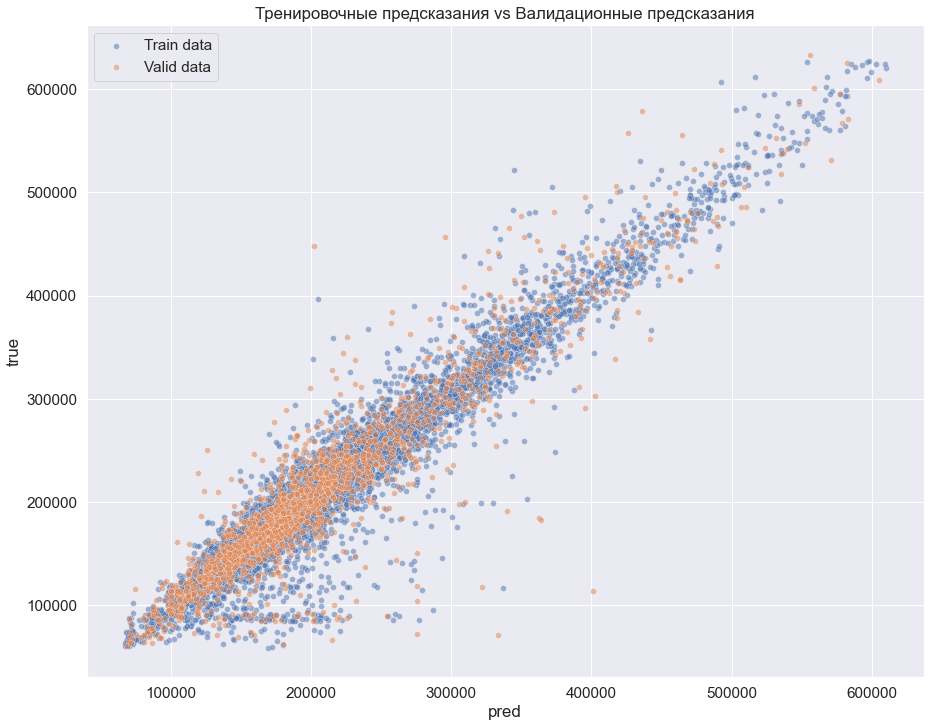

Время обработки: 0 час 0 мин 41.6 сек

                         features  importances
39  med_district_year_rooms_price         6133
31       med_Social_2_rooms_price         3036
2                          Square         2258
5                           Floor         1544
20                       rm_ratio         1420
41    med_social_year_rooms_price         1385
38      med_year_floor_rooms_psqm         1263
21                       other_sq         1251
19                       kt_ratio         1156
37     med_year_floor_rooms_price         1060
40   med_district_year_rooms_psqm          986
32        med_Social_2_rooms_psqm          825
3                      LifeSquare          813
22                     int_square          654
0                      DistrictId          512
27     med_DistrictId_rooms_price          477
42     med_social_year_rooms_psqm          460
6                      HouseFloor          450
4                   KitchenSquare          436
7                    

In [103]:
# финальный тюнинг модели
f_params = {'boosting_type': ['dart'],
#             'boosting_type': ['dart', 'gbdt'],
#             'max_bin': [128, 256, 512],    
            'n_estimators': [1100],
#             'n_estimators': list(range(950, 1151, 50)),
            'max_depth': [5],
            'learning_rate': [.05]
#             'learning_rate': [.01, .02, .05, .08, .1]
}
_, feat_imp_df_, name_submit = process_model(model, params=f_params, fold_single=5,
                                             verbose=1, build_model=True)
print()
print(feat_imp_df_)
print(f'\n\nПредсказания выгружены в файл:\n{name_submit}')

In [104]:
print('Общее время выполнения:')
print_time(global_start_time)

Общее время выполнения:
Время обработки: 0 час 2 мин 43.4 сек


#### Профиль на Каггле 
https://www.kaggle.com/saspav ник Sas Pav

P.S. в результате экспериментов было обучено 233 модели, полученые предсказания усреднены,результат был загружен на Каггл и получил наибольшую оценку. 

Я понимаю, что не следовал общепринятой методике, т.к. объединил все данные в один датасет для обсчета медиан и выполнил много точечных изменений, мне хотелось узнать насколько близко я смогу подобраться к лидерам. И еще заметил, что переобученные модели, это когда на кроссвалидацию вместо данных

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)     

я отдавал весь тренировочный набор X, y - тогда полученная модель выдавала больший результат на Каггле.

После завершения курса я планирую переписать код под общепринятые правила и посмотрю на результат. Также хочу попробовать BaggingRegressor и StackingRegressor.